In [107]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./input/test.csv
./input/train.csv


In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import copy
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression, ElasticNet

In [80]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

In [81]:
print((train.isna().sum()[train.isna().sum() > 0]))

print("Number of train data: ",len(train))

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
Number of train data:  1460


In [82]:
numerical_columns_train = train.select_dtypes(exclude=['object']).columns.tolist()
numerical_columns_train.remove("Id")

In [83]:
plt.figure(figsize = (6,6))
sns.heatmap(data = train[numerical_columns_train].corr(), annot = False, cmap = 'coolwarm' )

<Axes: >

In [84]:
data = pd.concat([train, test])
data.fillna(0, inplace=True)

In [85]:
!pip install -q sweetviz

/opt/homebrew/Caskroom/miniforge/base/envs/reg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Done! Use 'show' commands to display/save.   |██████████| [100%]   00:11 -> (00:00 left)



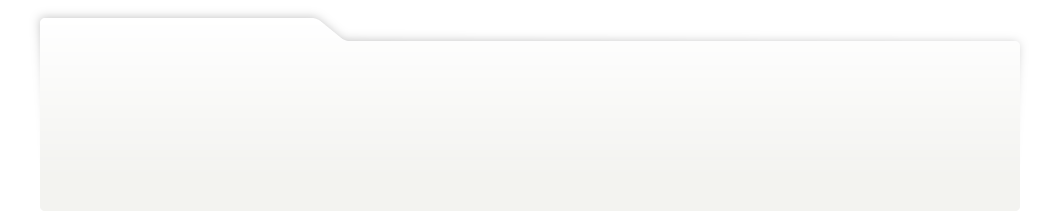
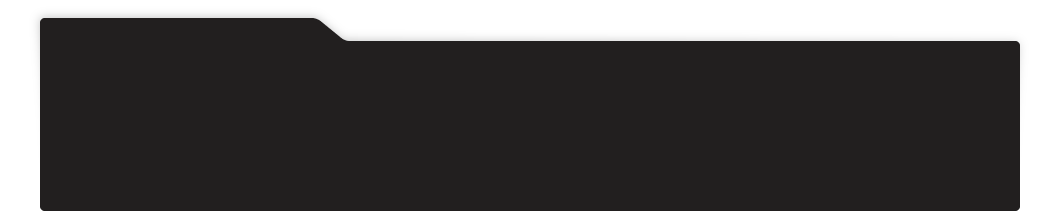
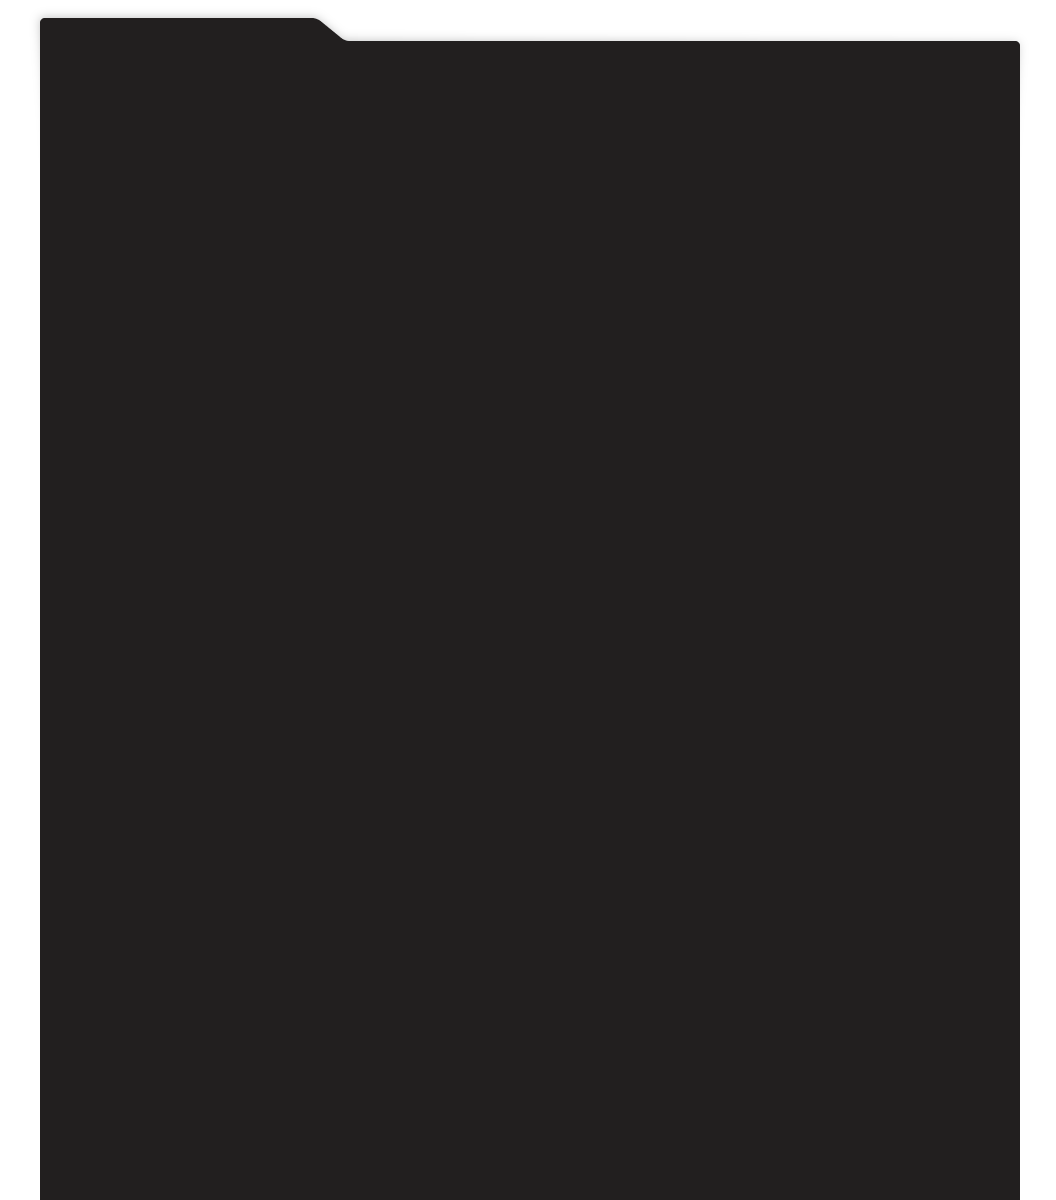
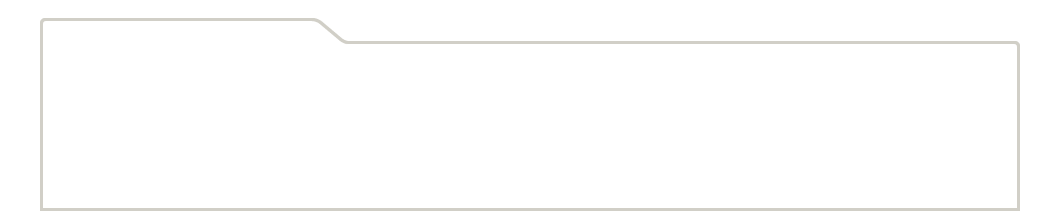
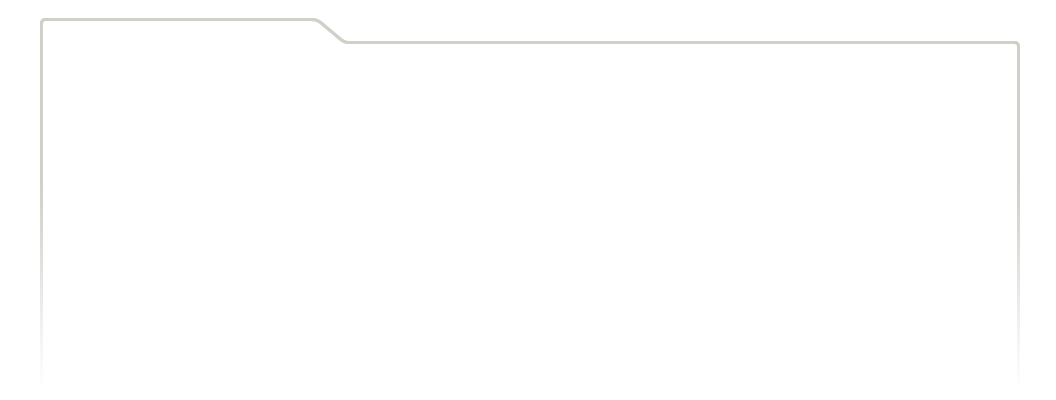
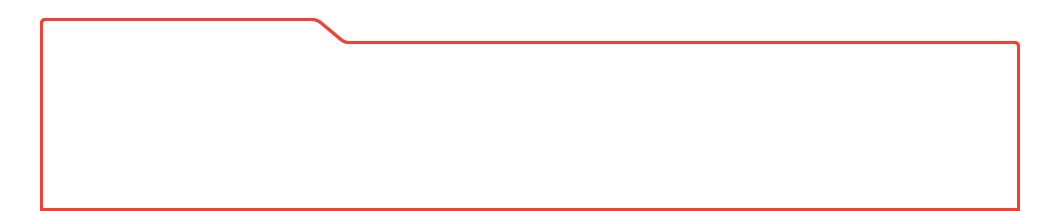
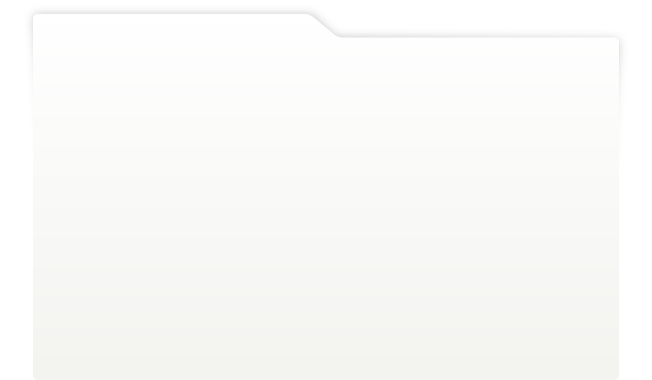
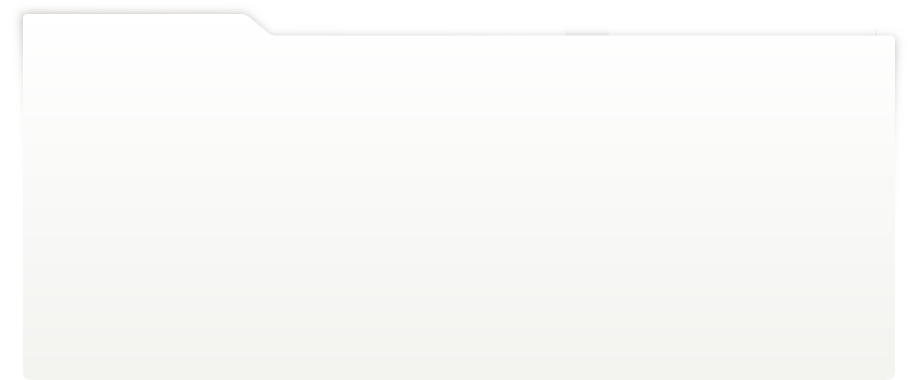
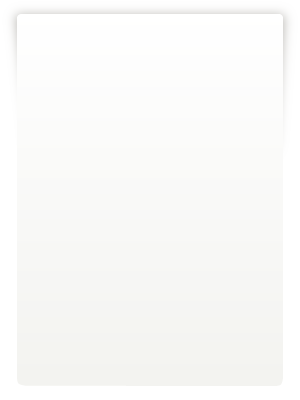
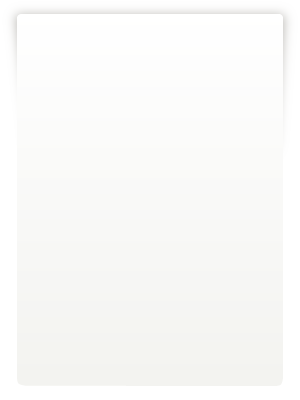
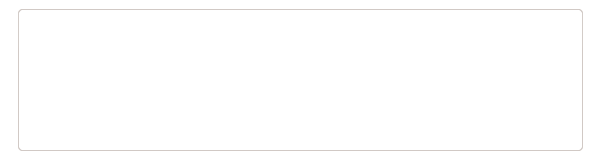
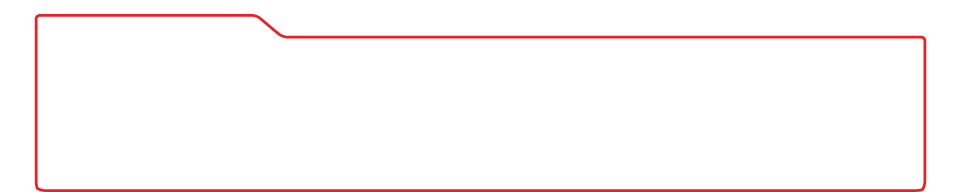
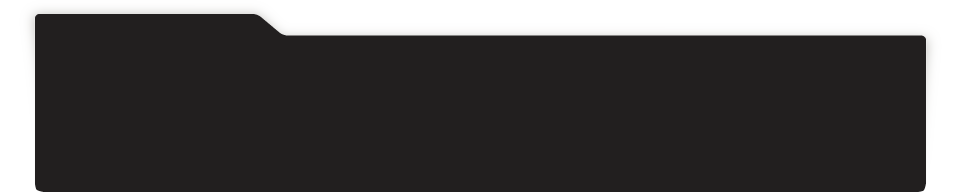
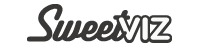
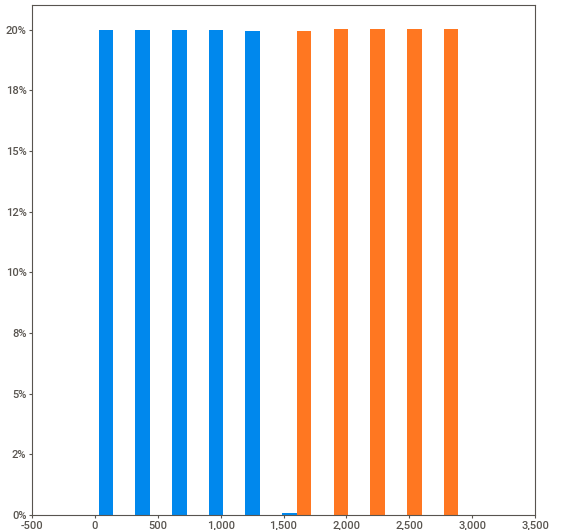
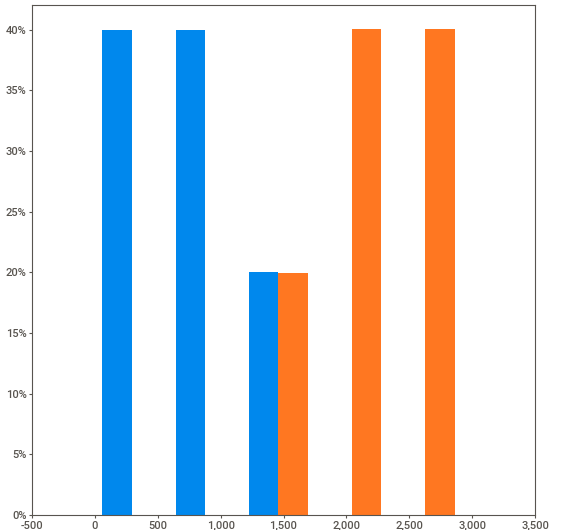
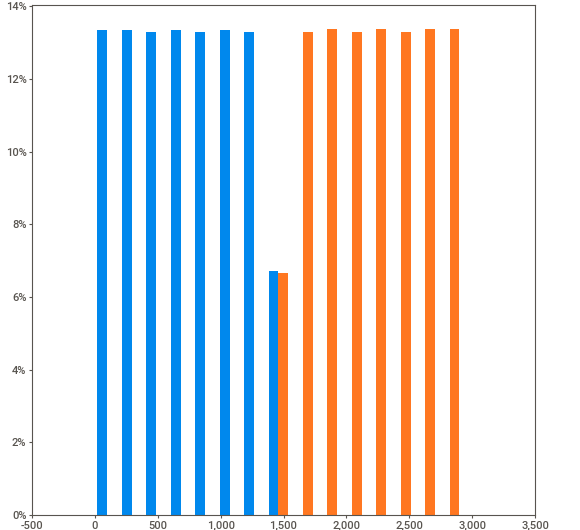
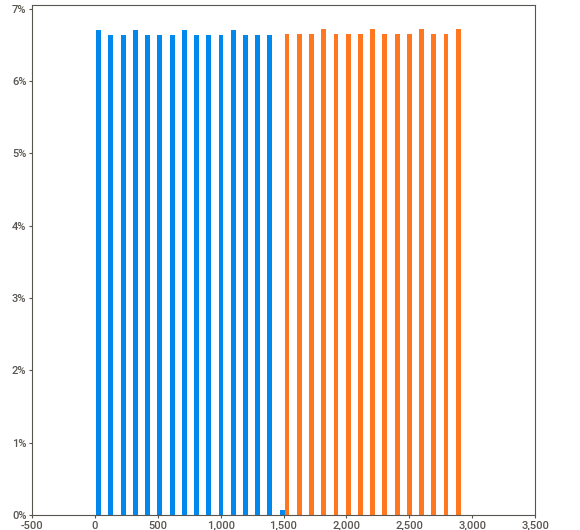
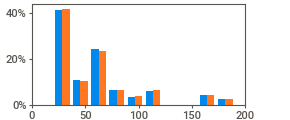
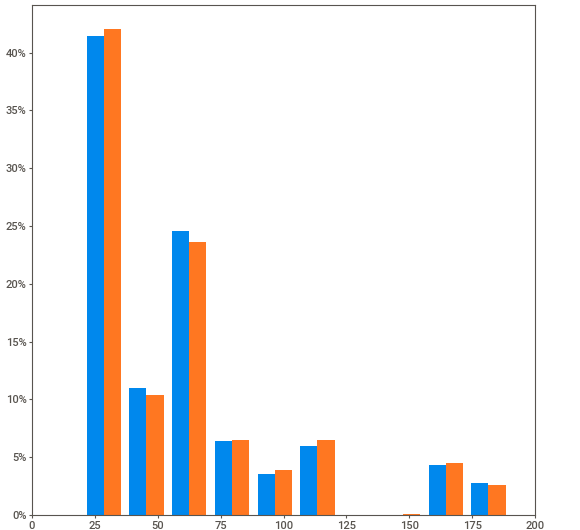
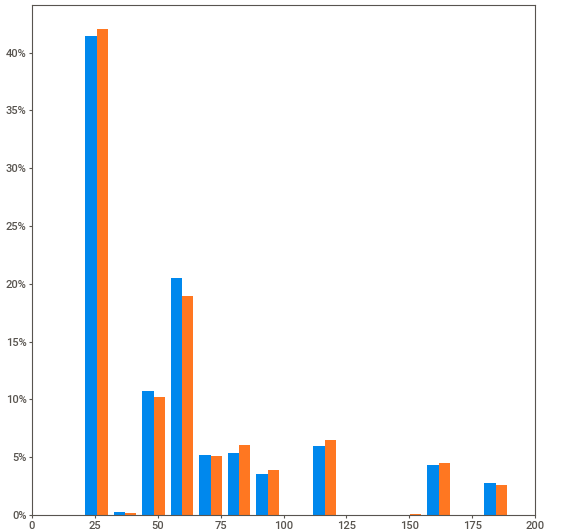
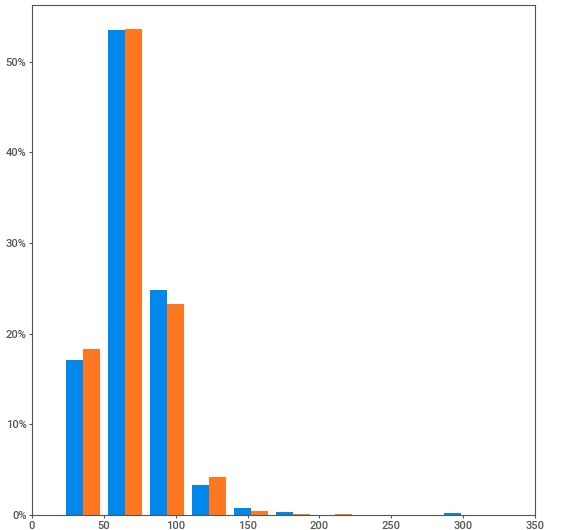
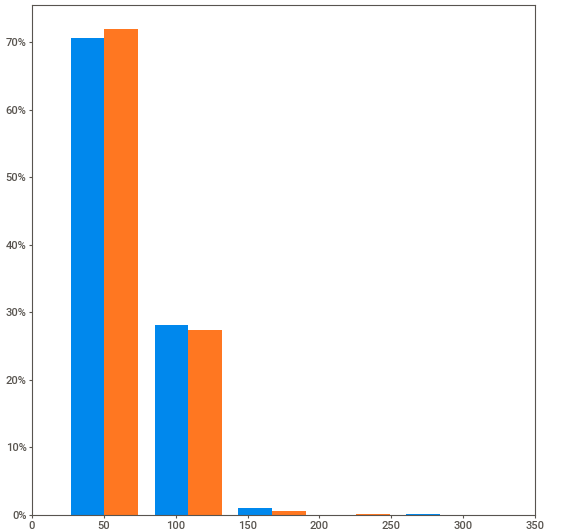
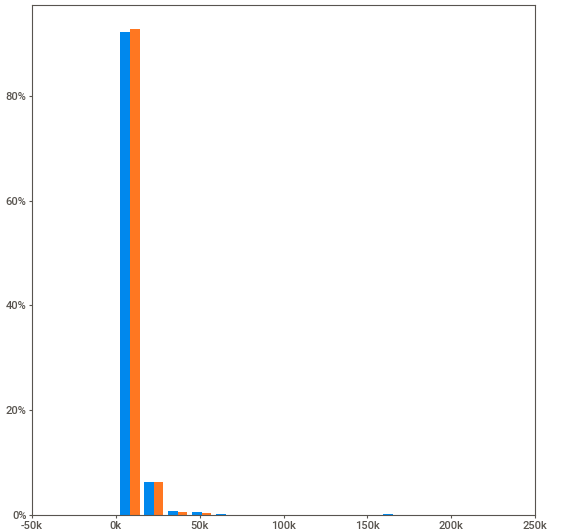
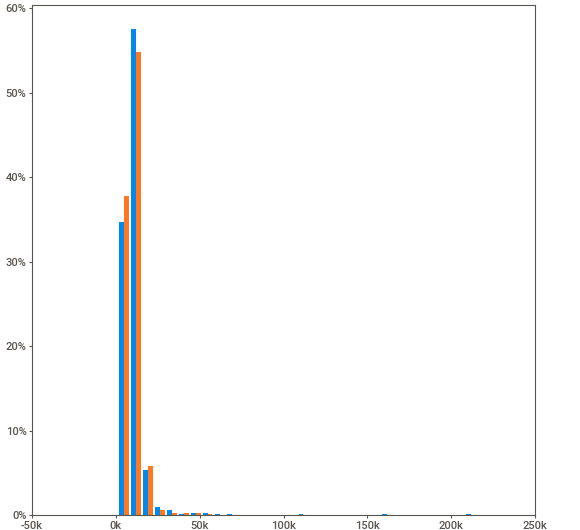
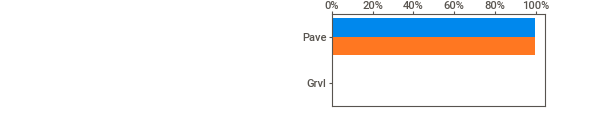
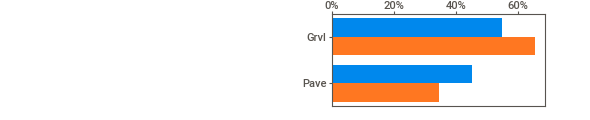
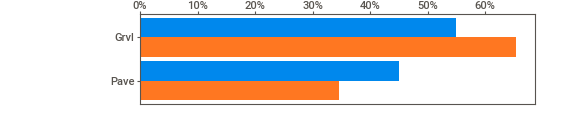
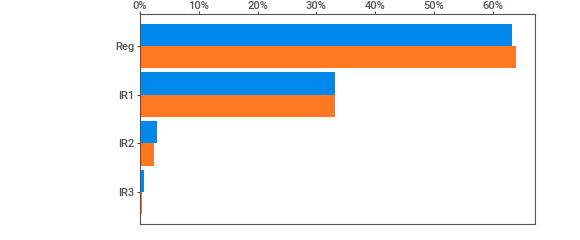
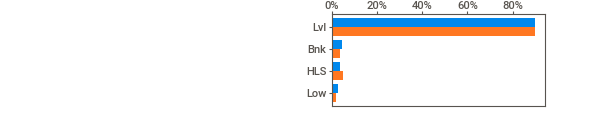
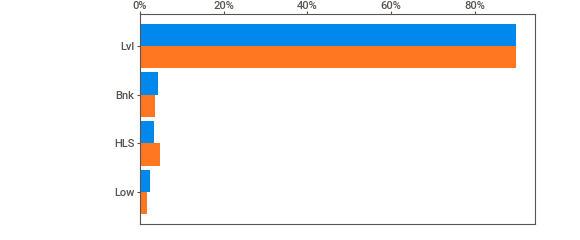
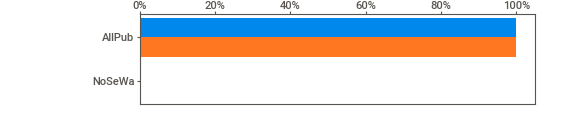
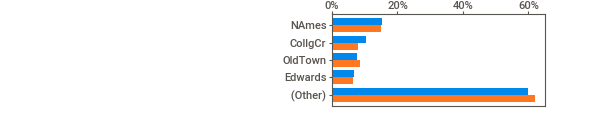
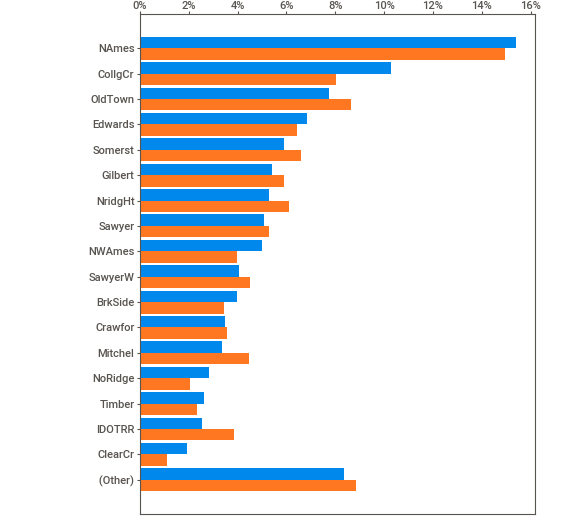
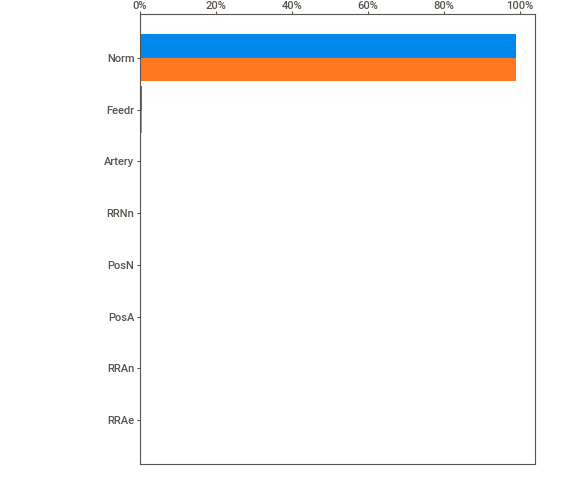
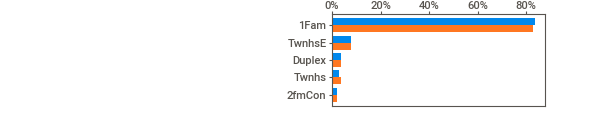
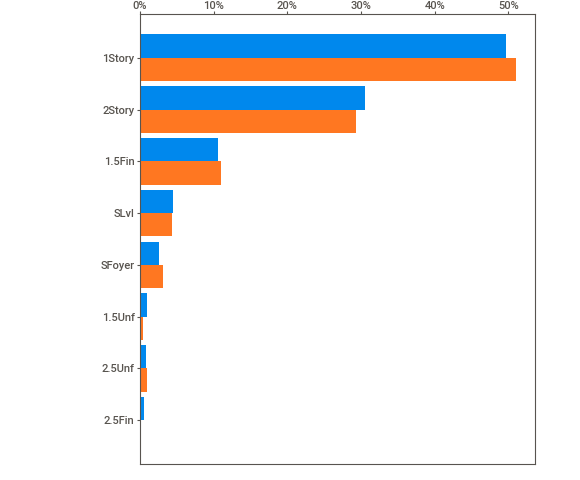
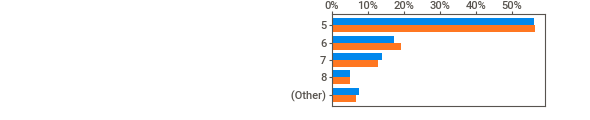
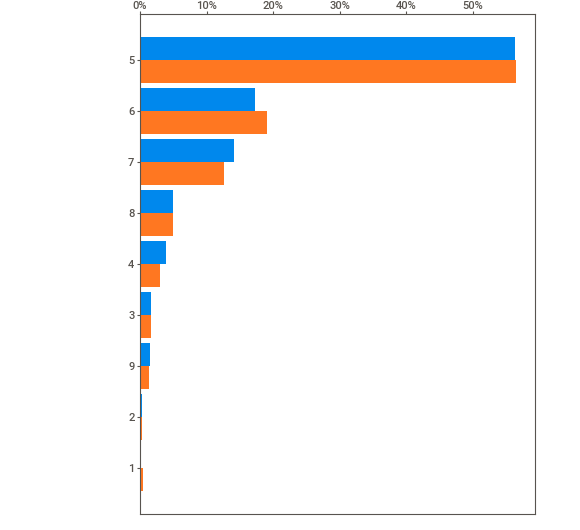
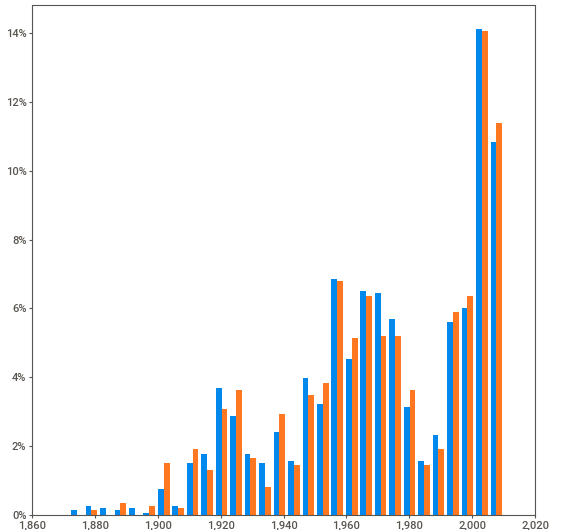
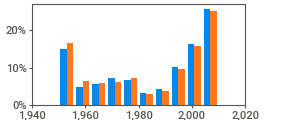
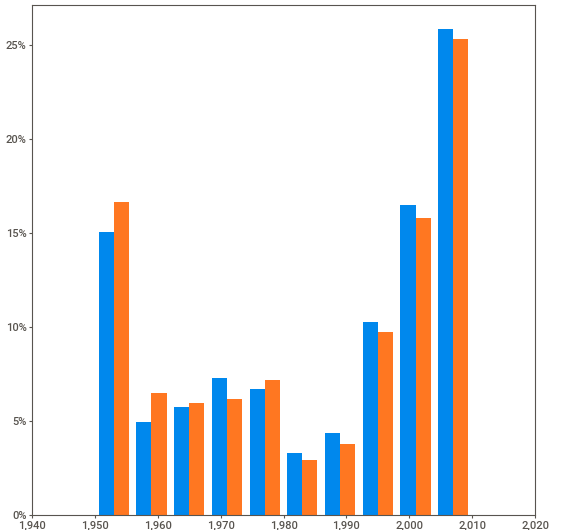
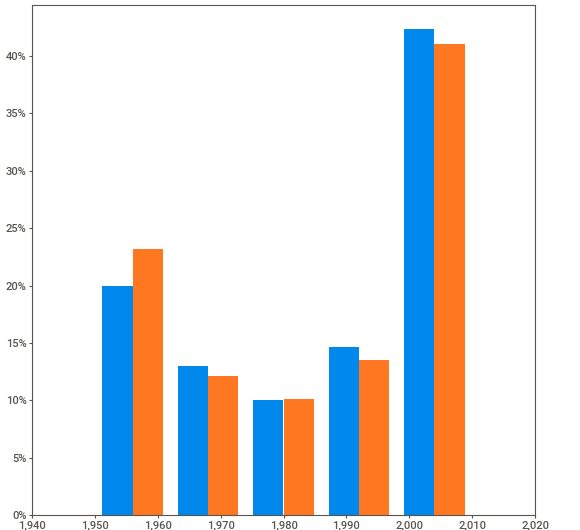
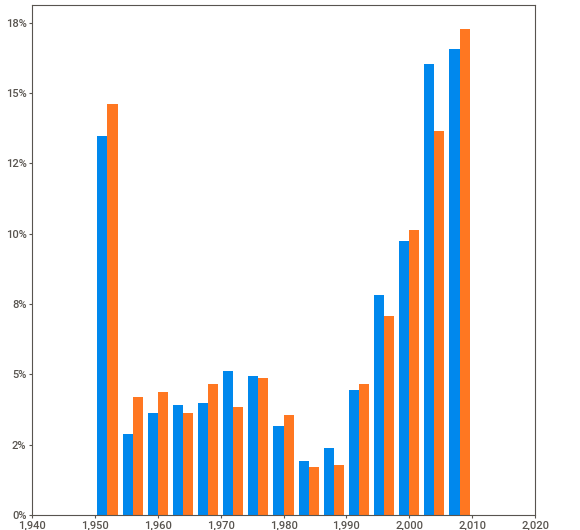
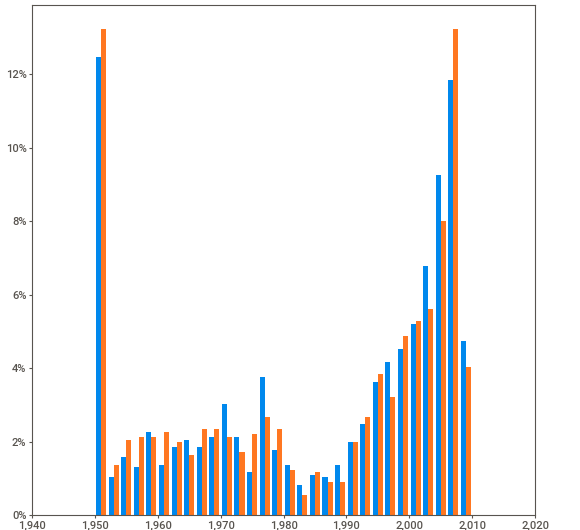
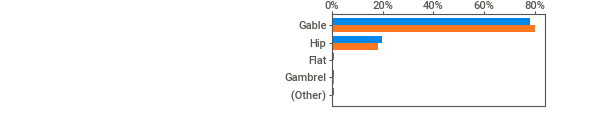
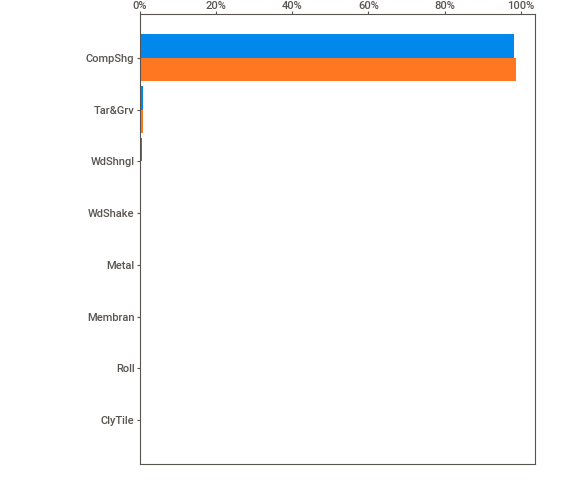
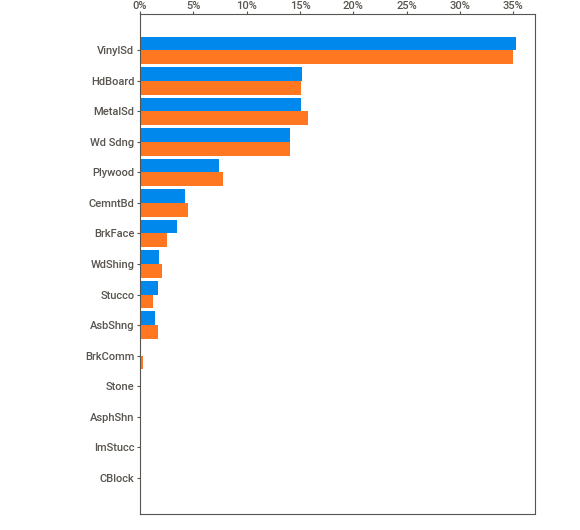
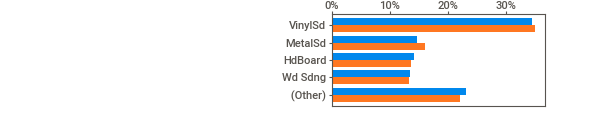
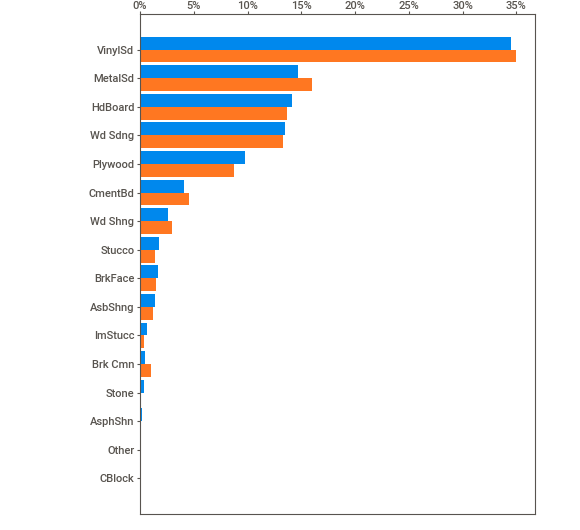
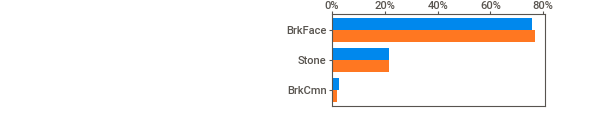
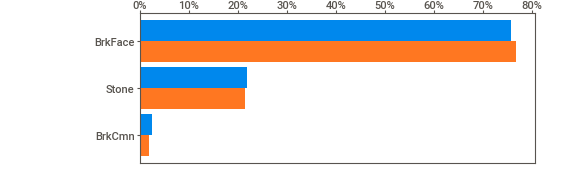
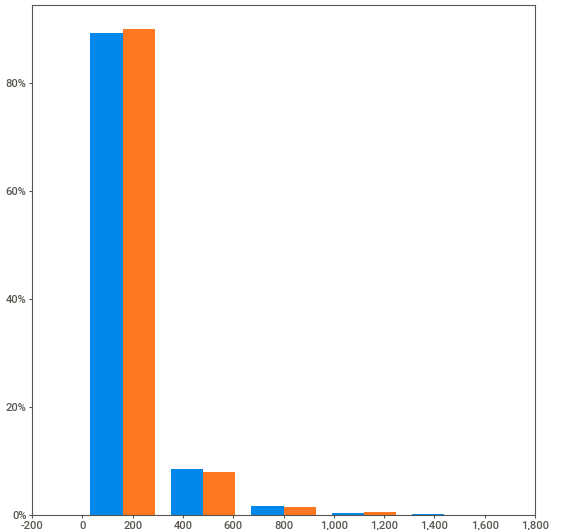
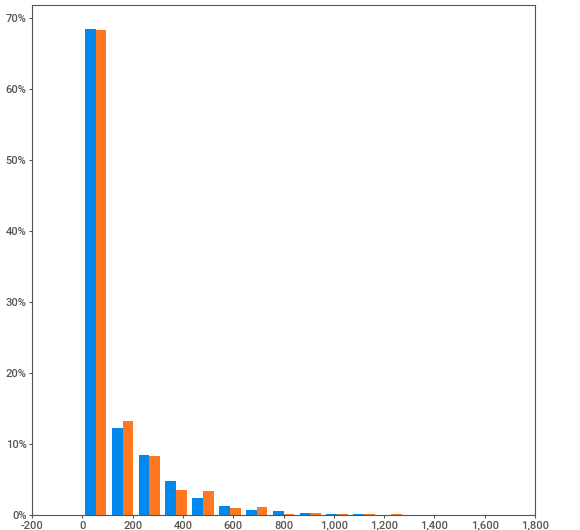
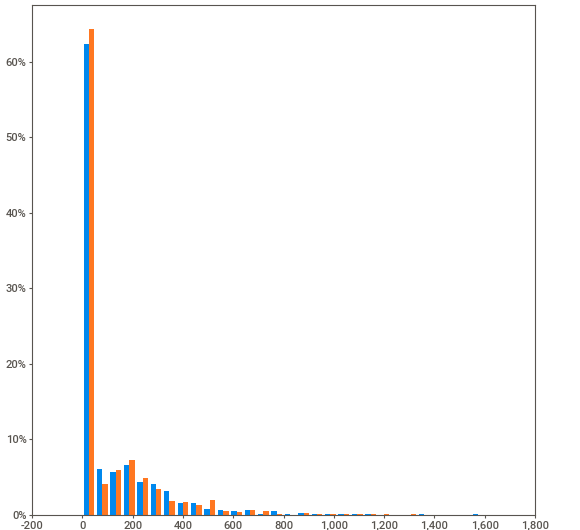
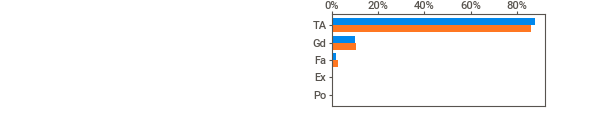
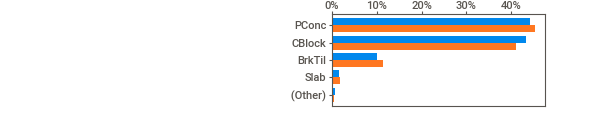
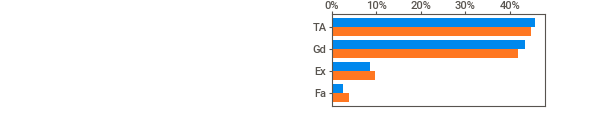
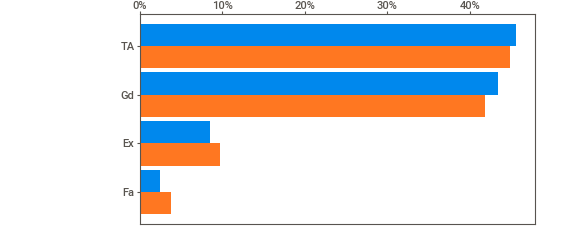
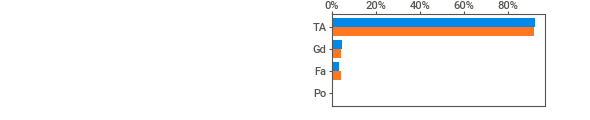
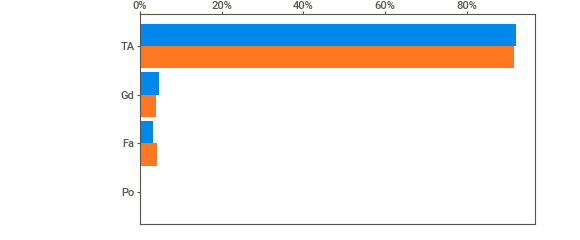
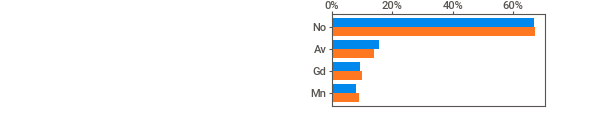
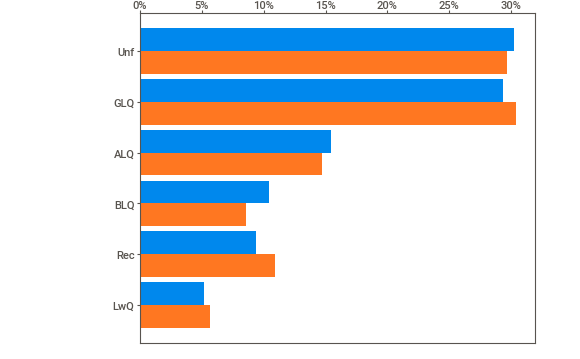
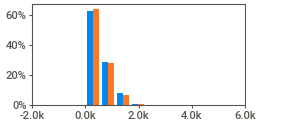
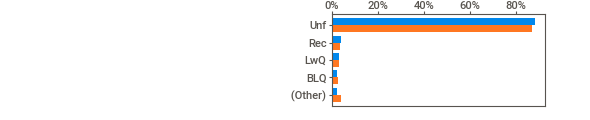
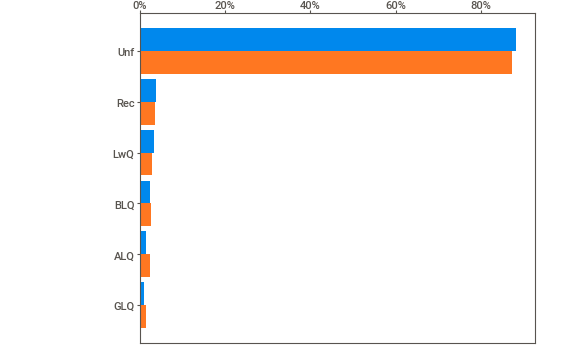
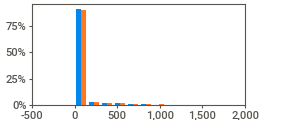
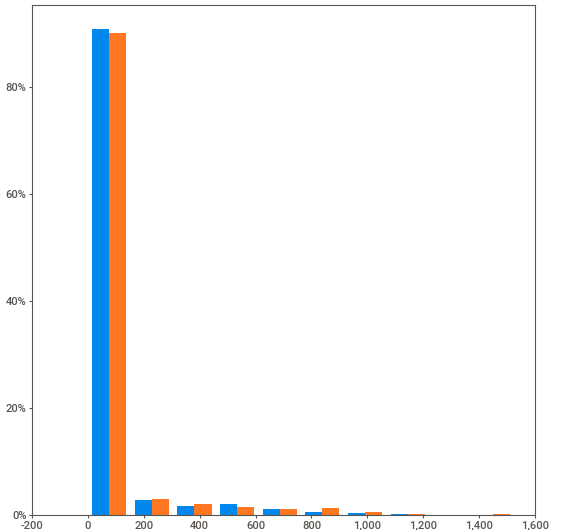
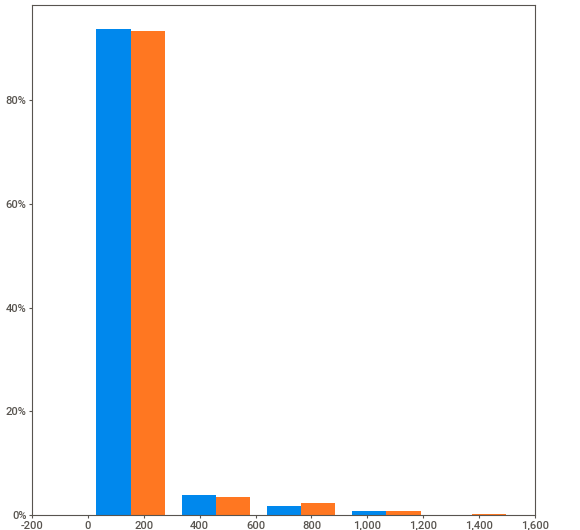
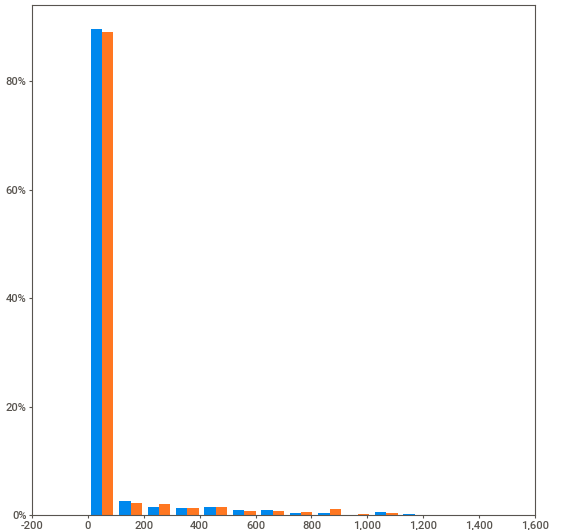
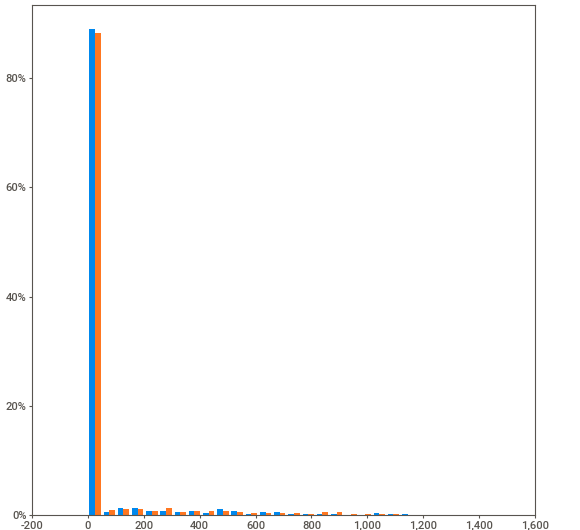
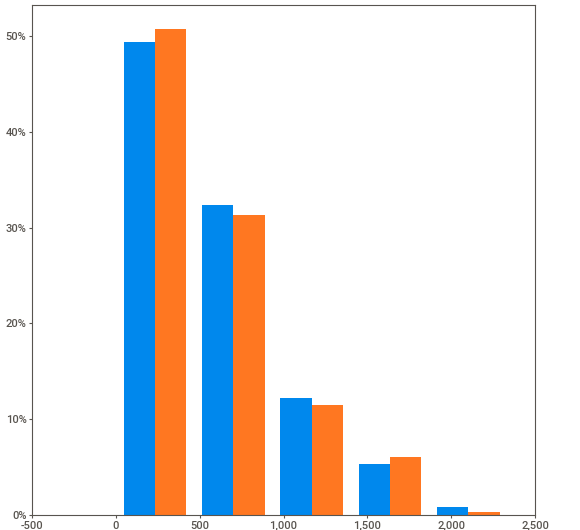
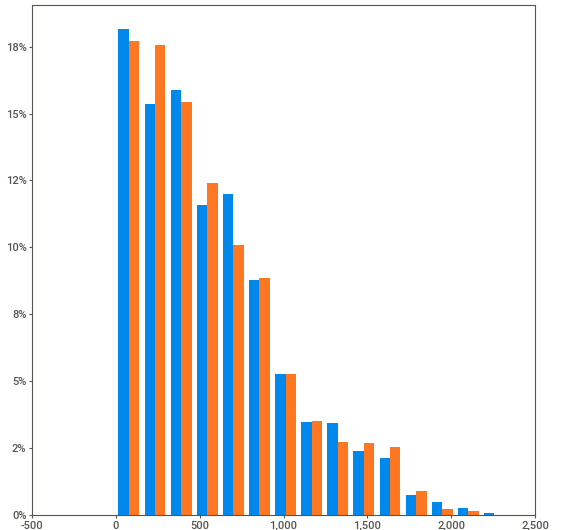
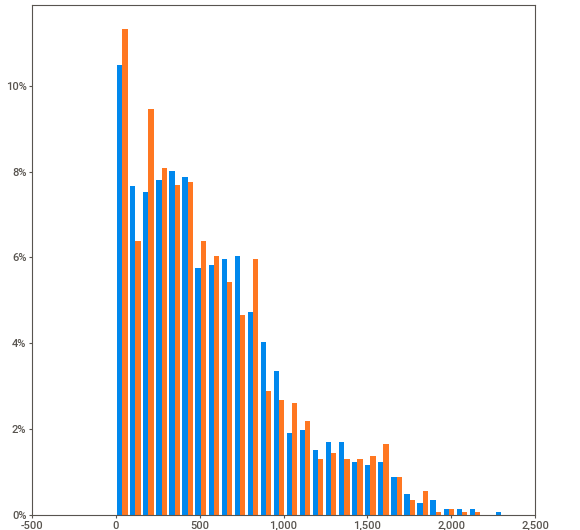
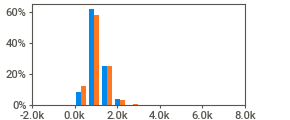
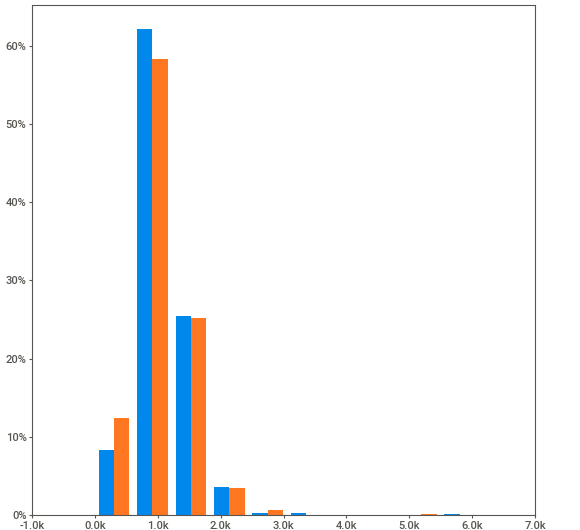
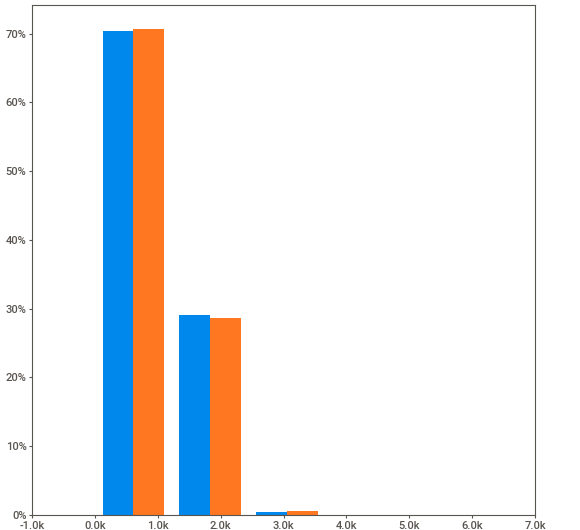
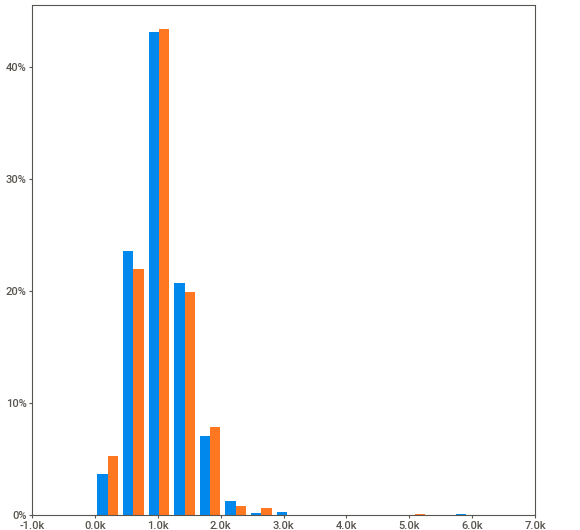
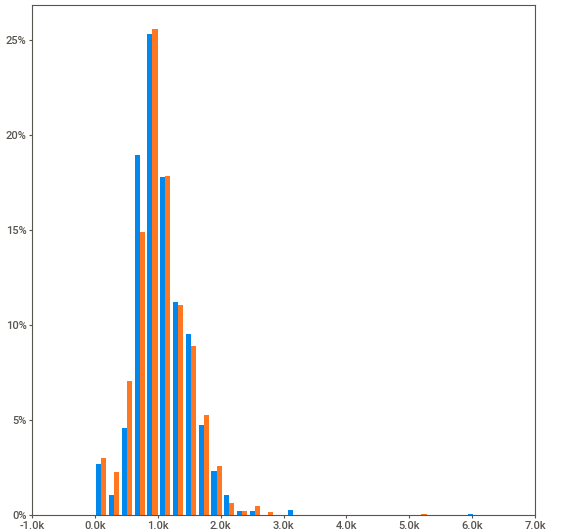
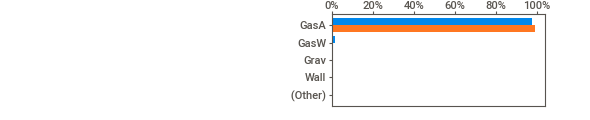
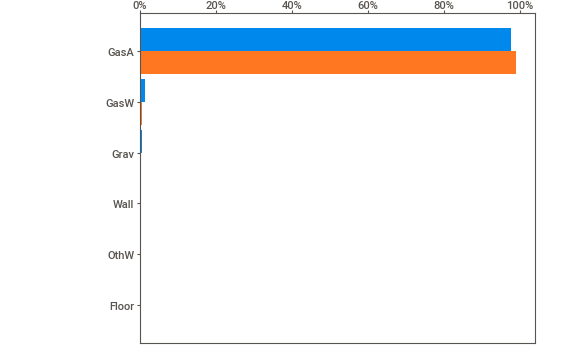
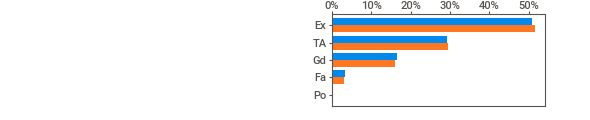
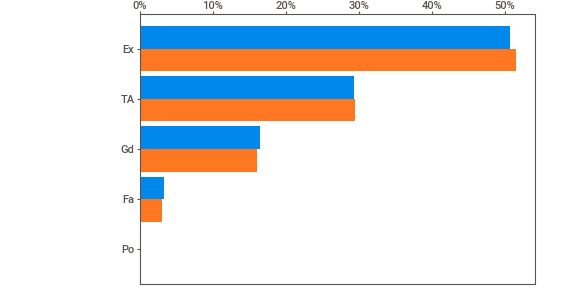
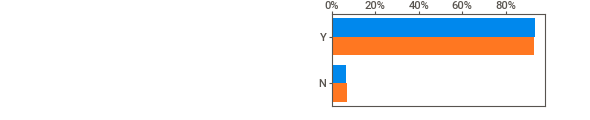
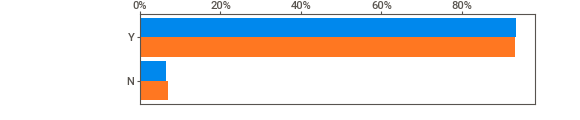
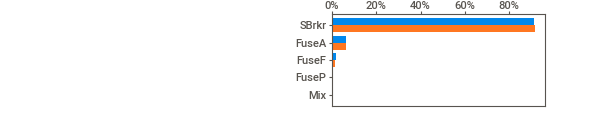
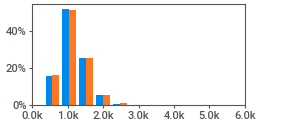
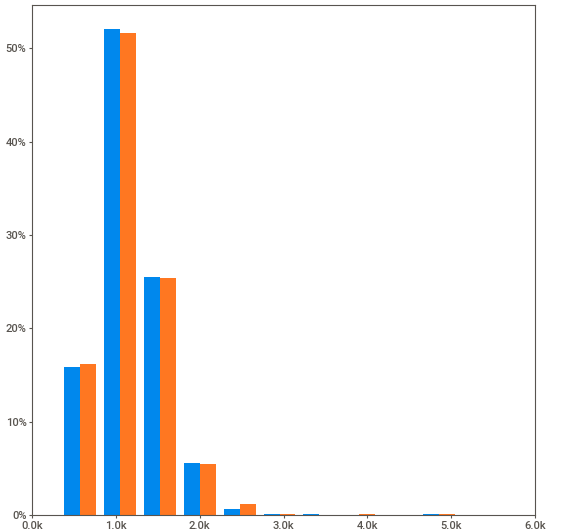
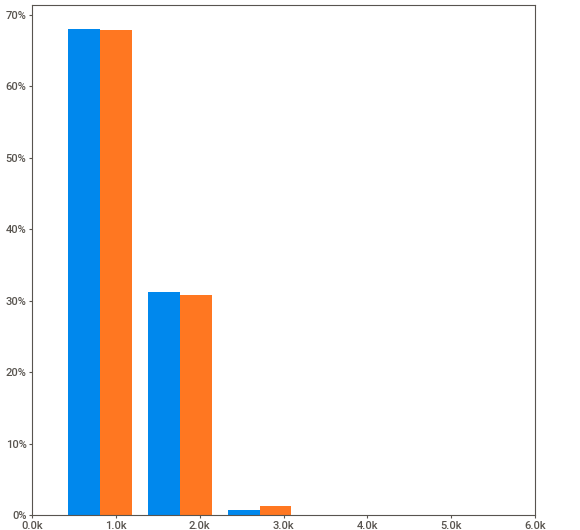
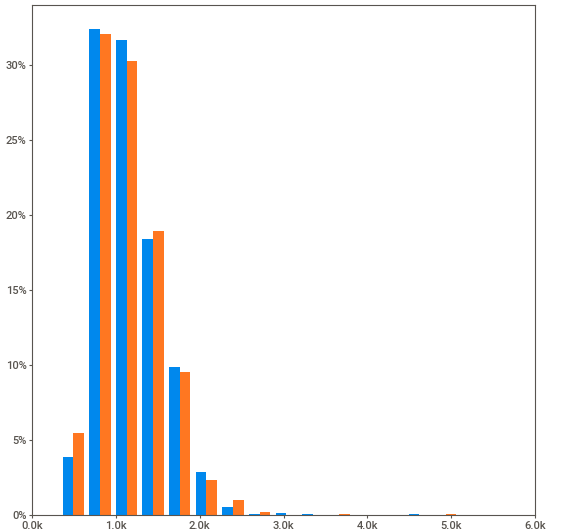
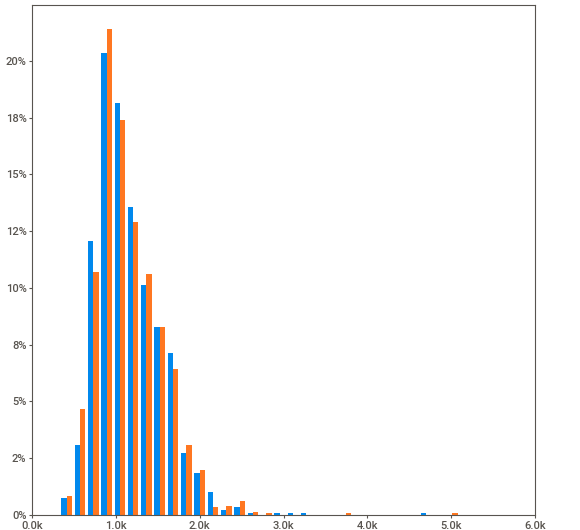
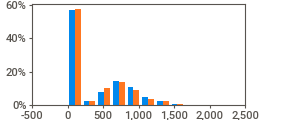
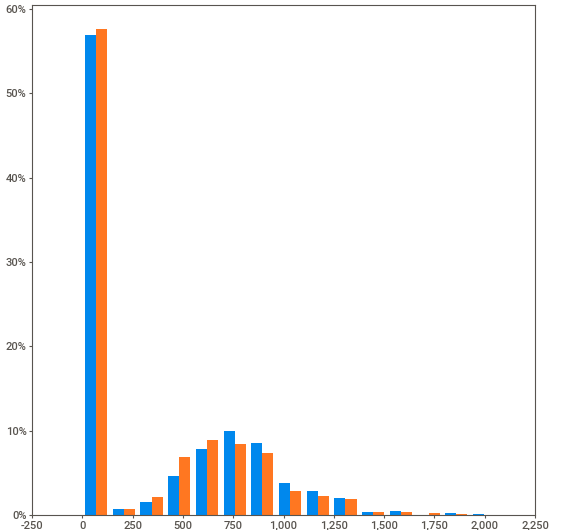
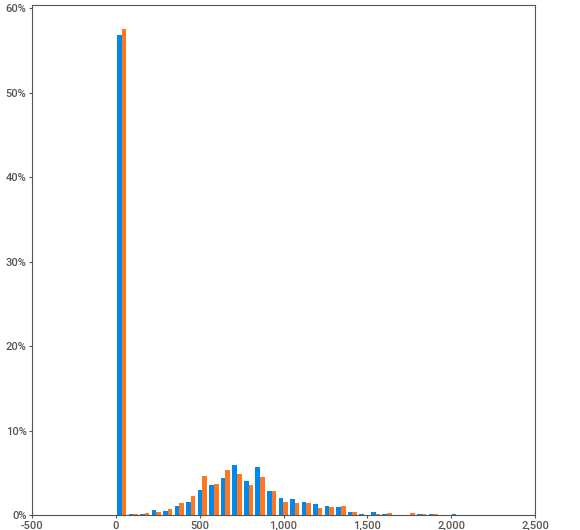
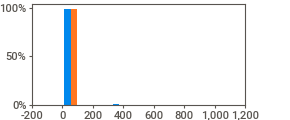
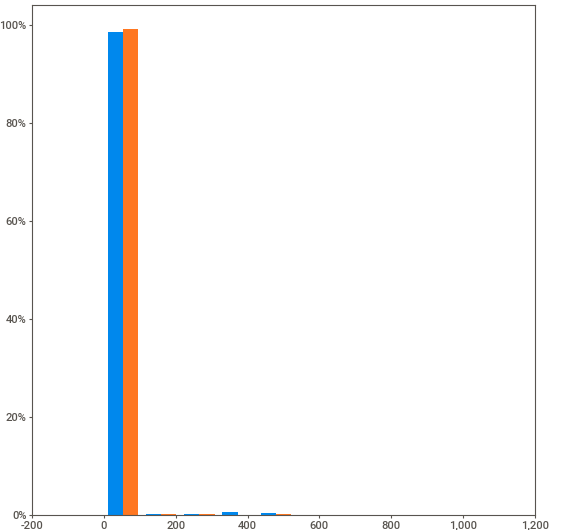
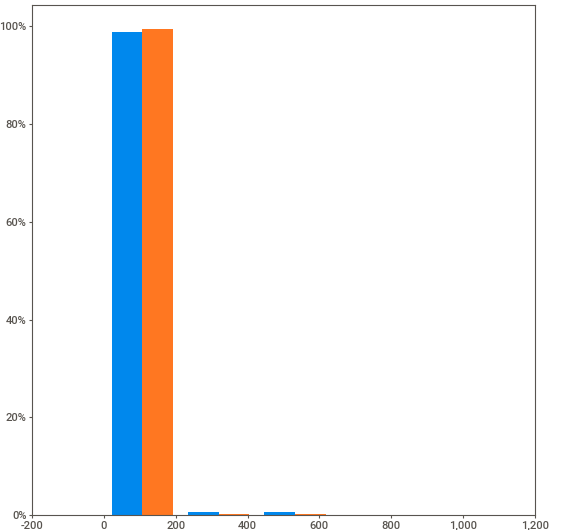
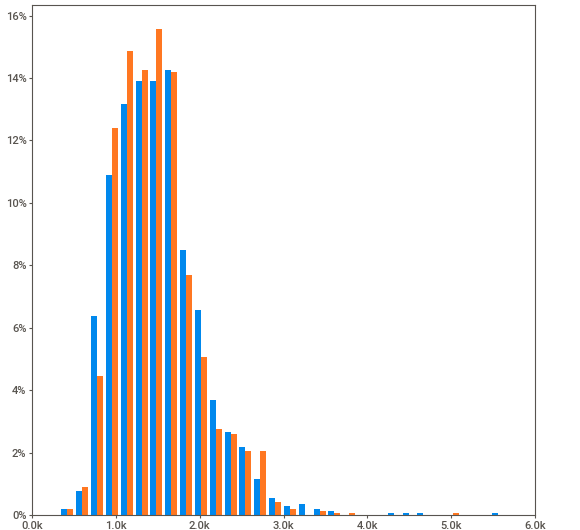
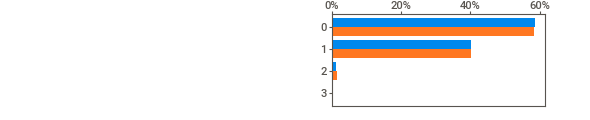
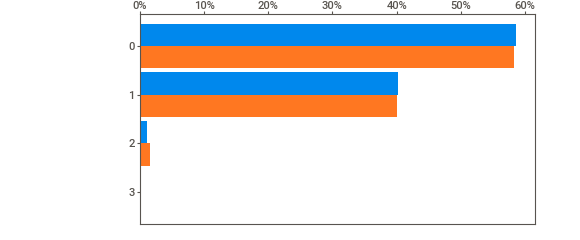
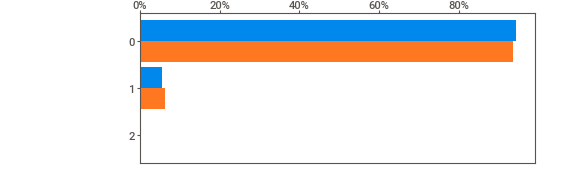
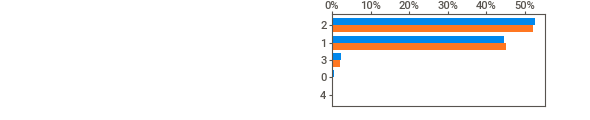
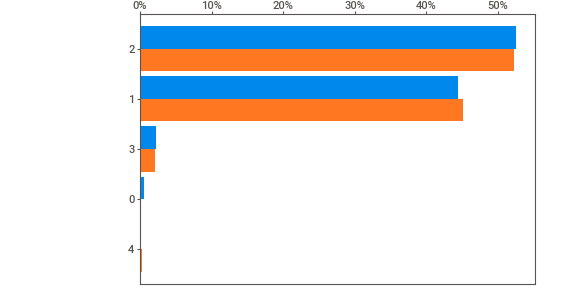
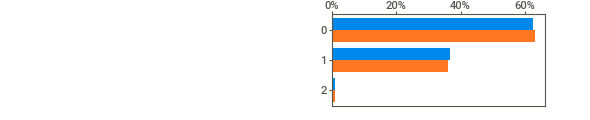
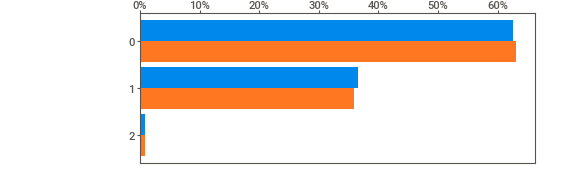
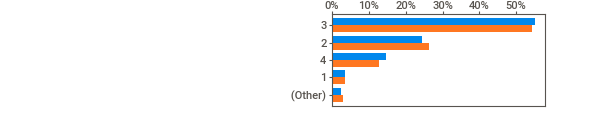
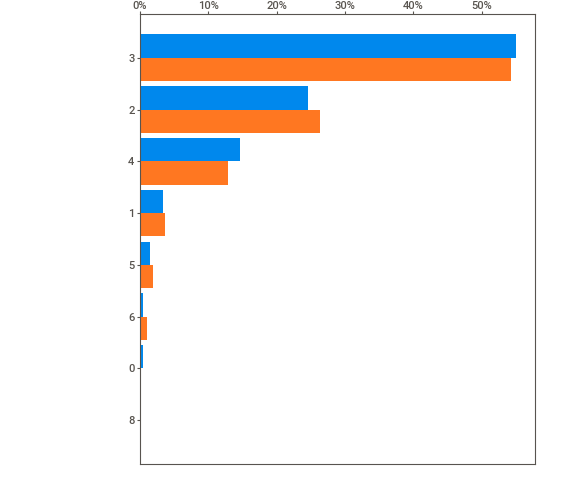
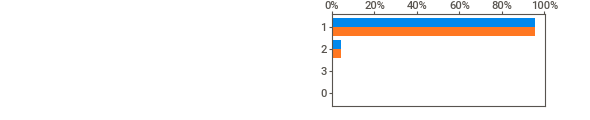
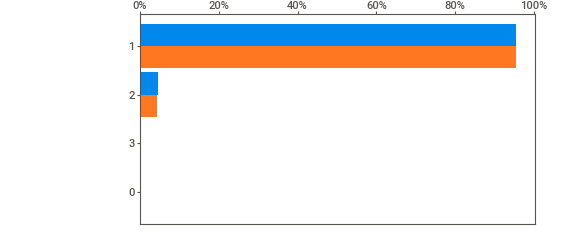
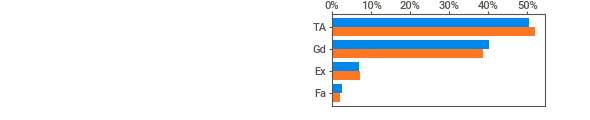
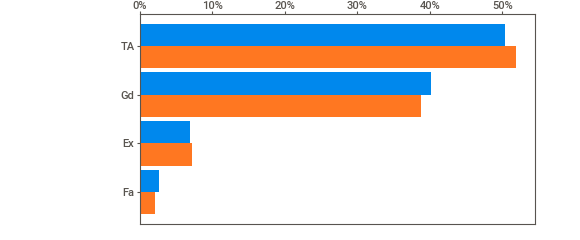
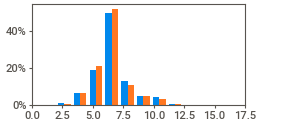
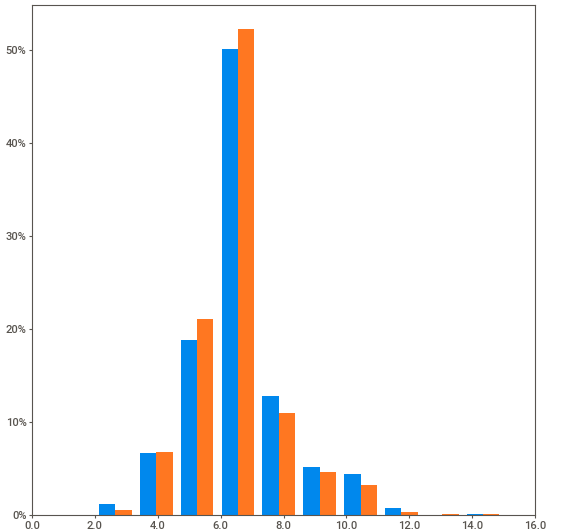
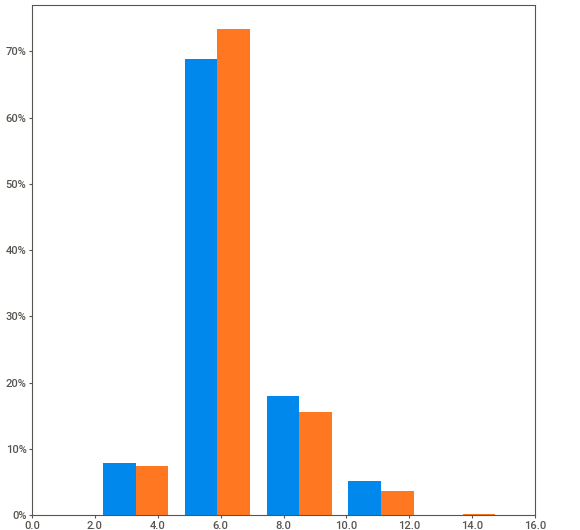
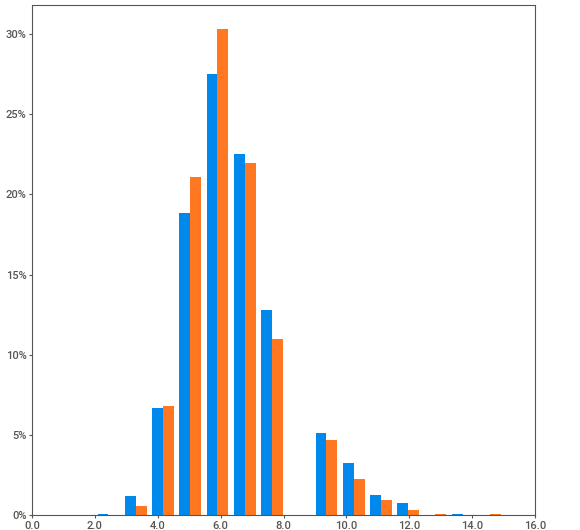
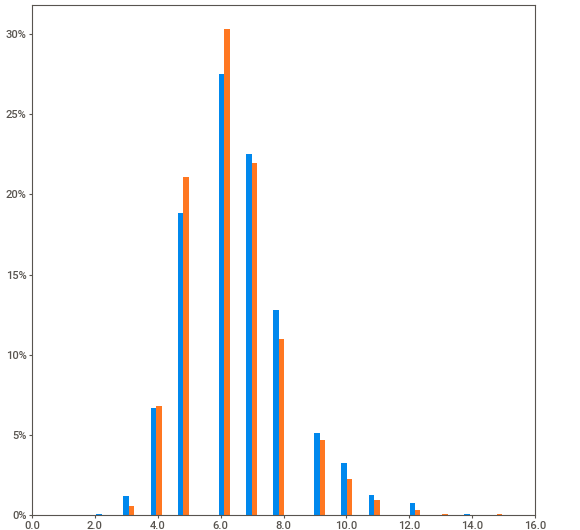
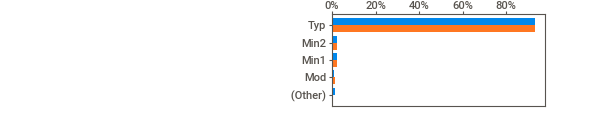
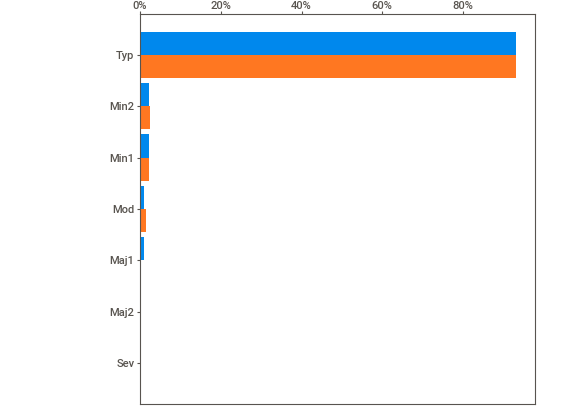
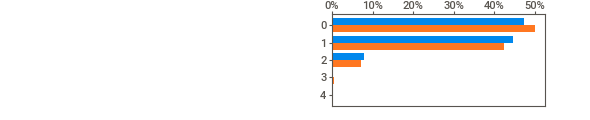
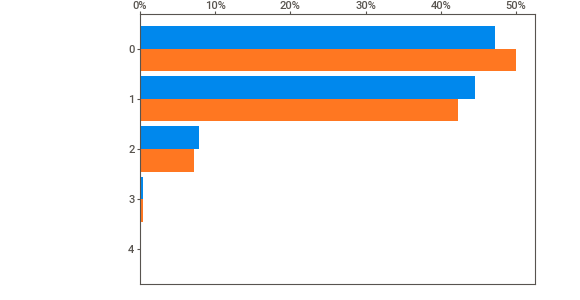
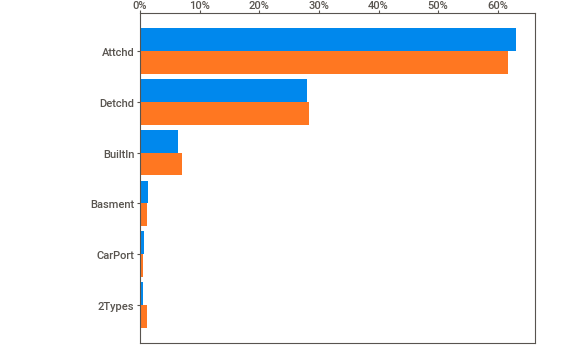
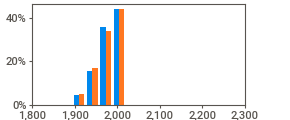
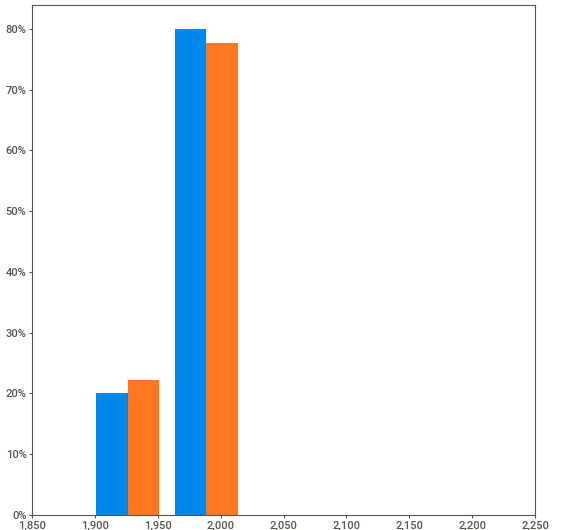
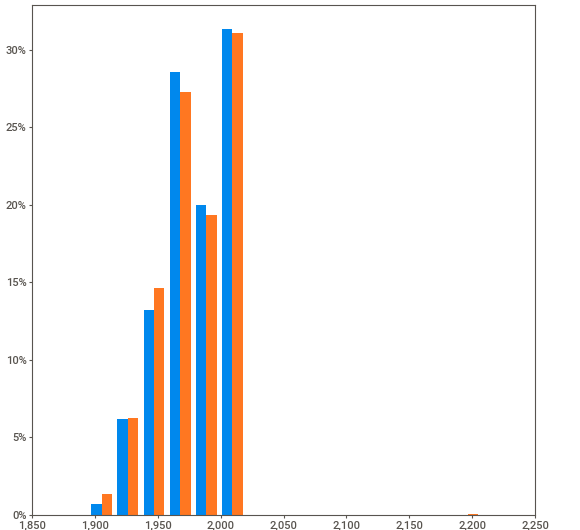
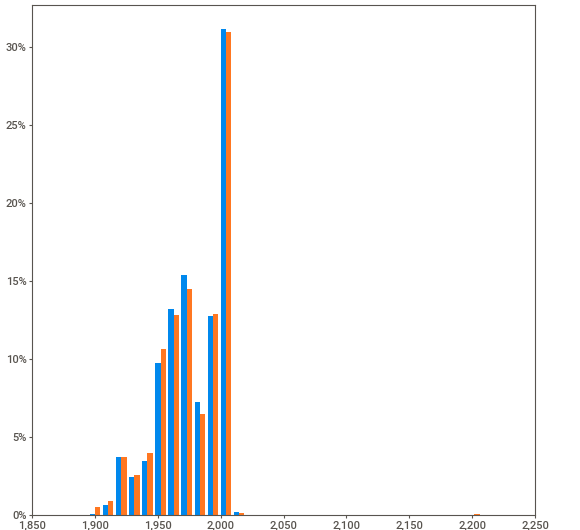
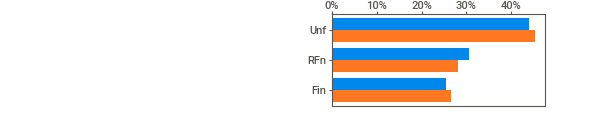
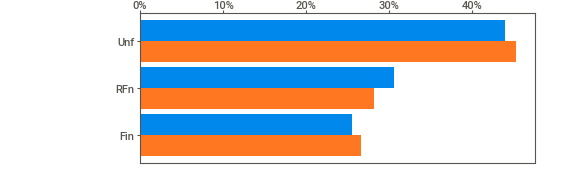
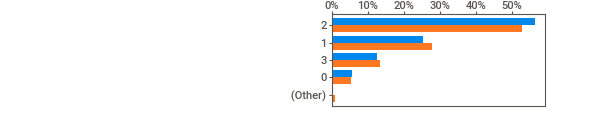
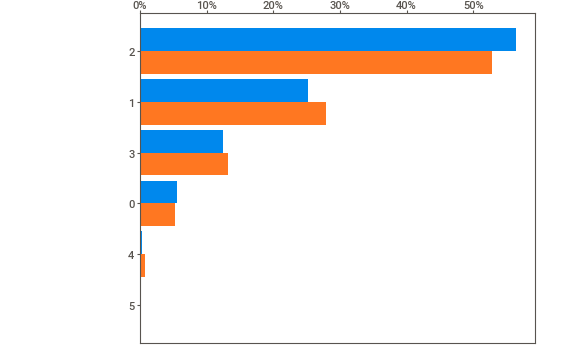
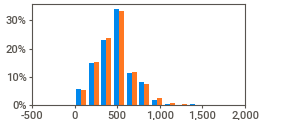
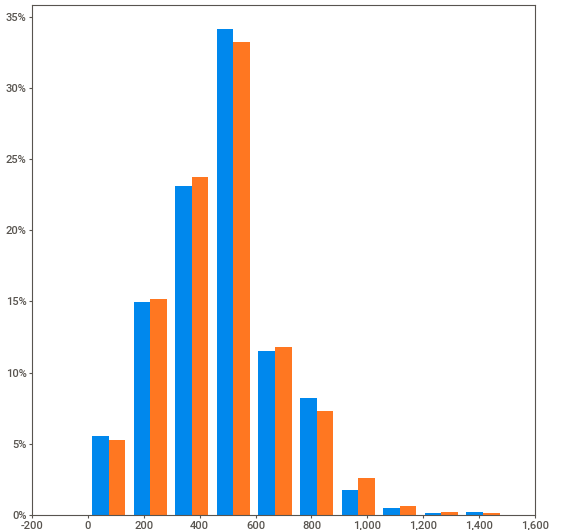
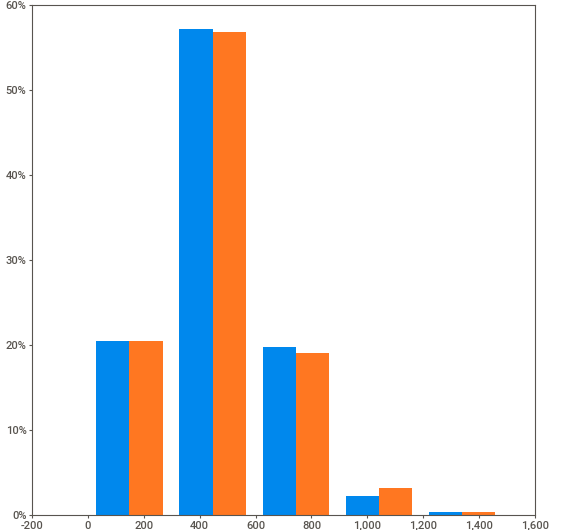
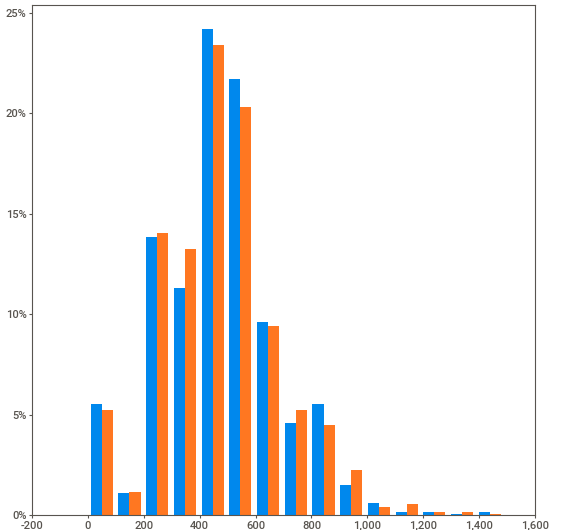
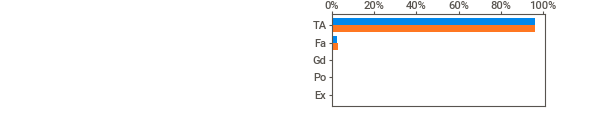
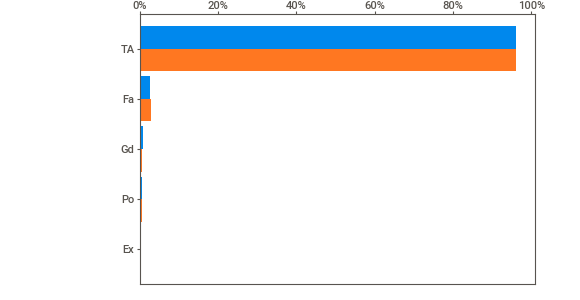
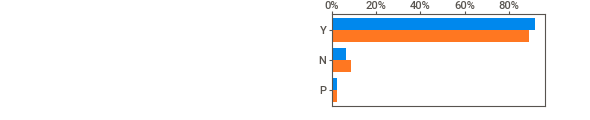
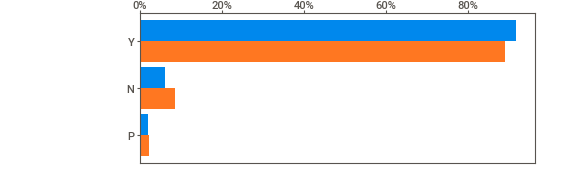
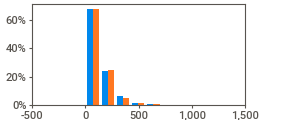
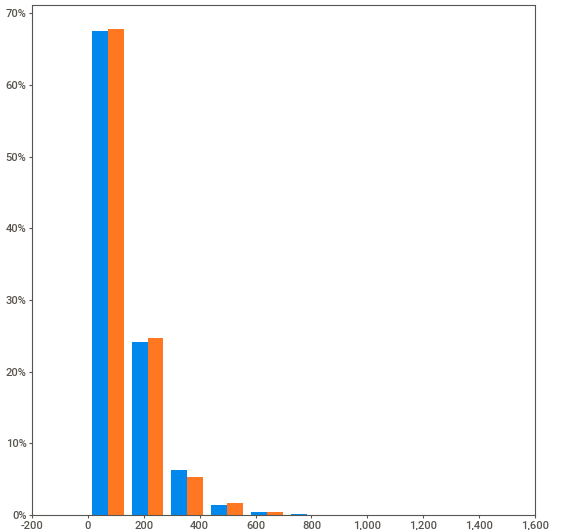
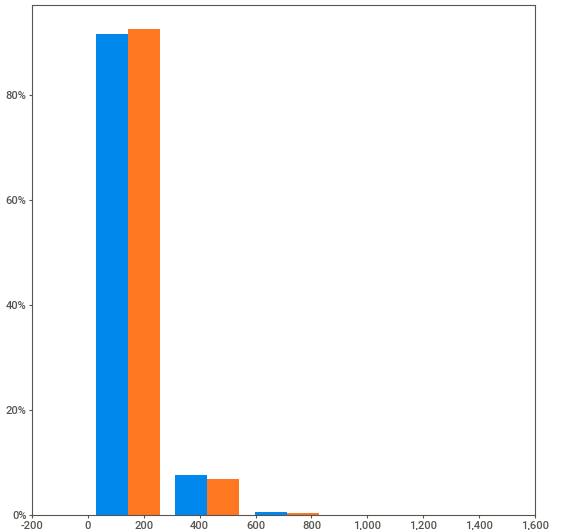
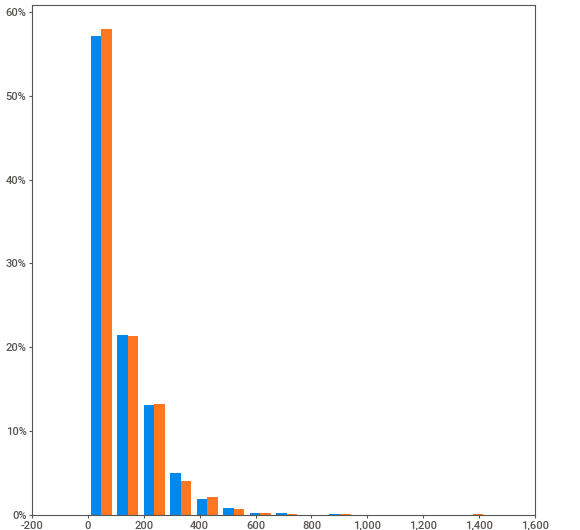
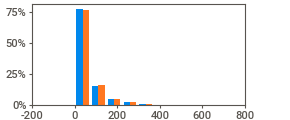
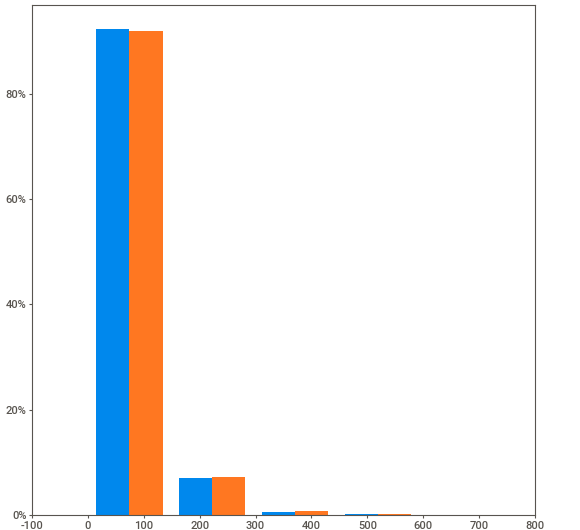
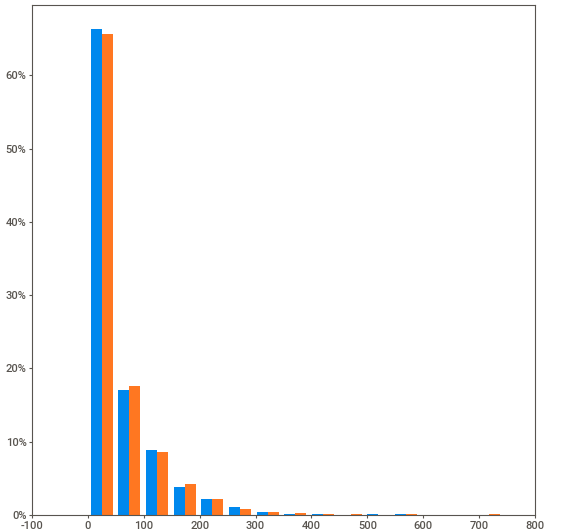
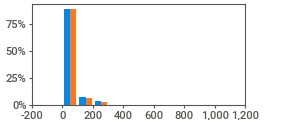
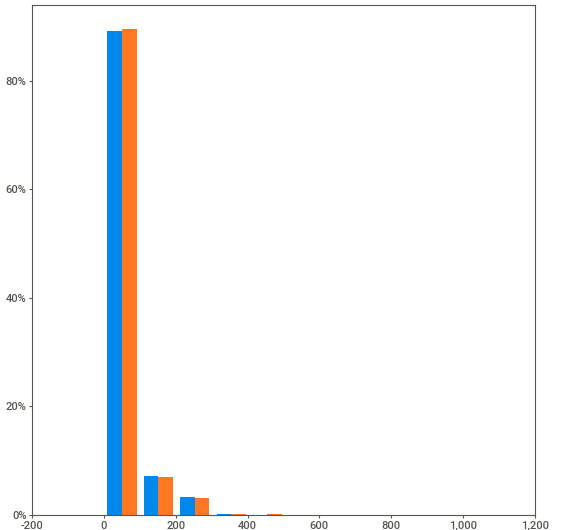
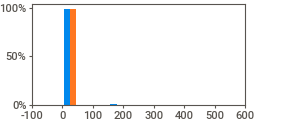
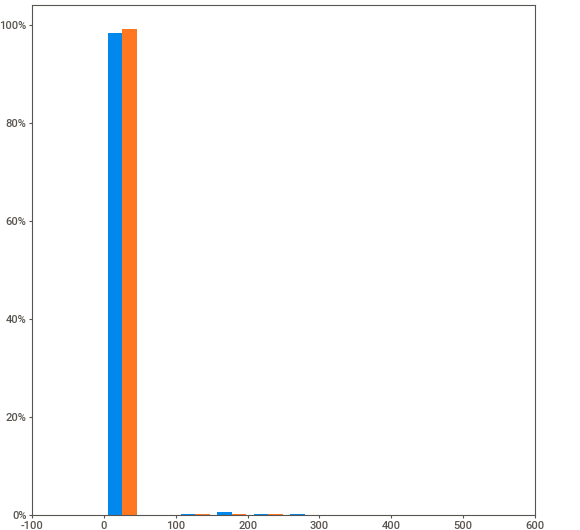
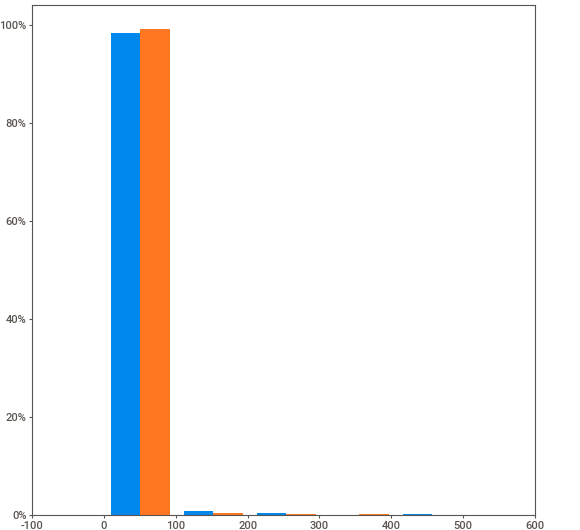
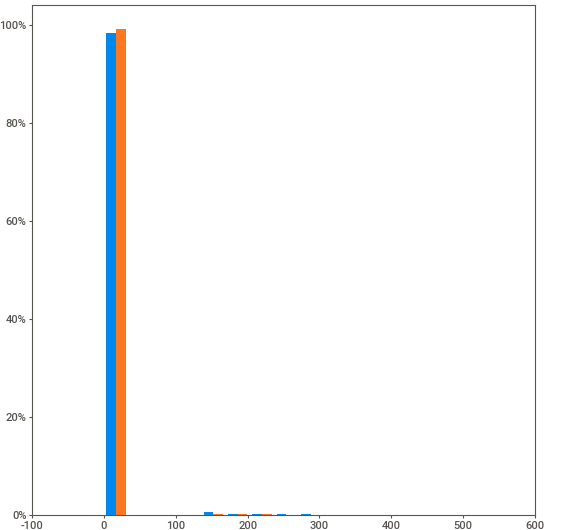
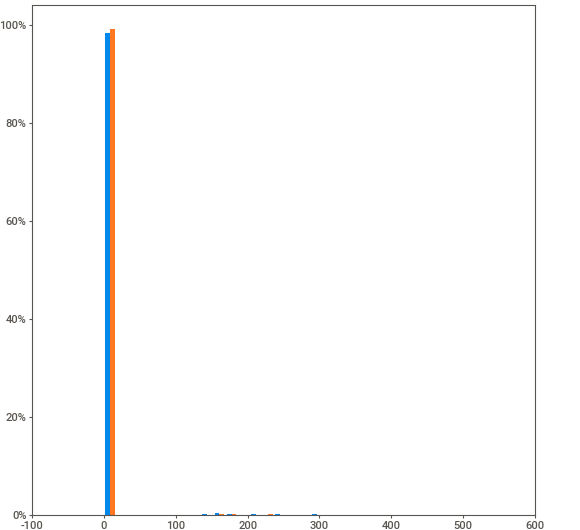
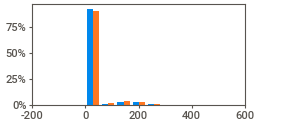
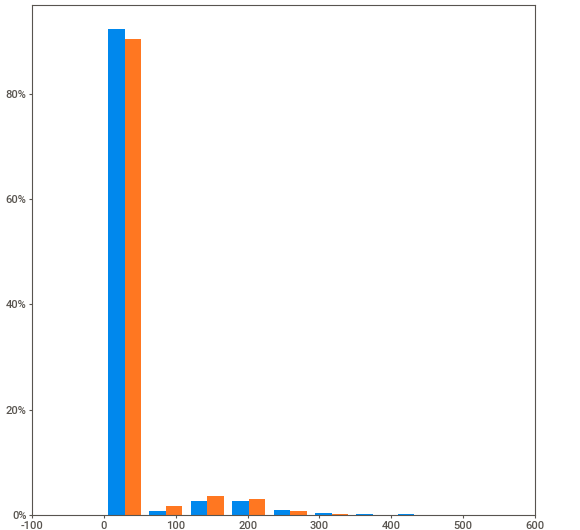
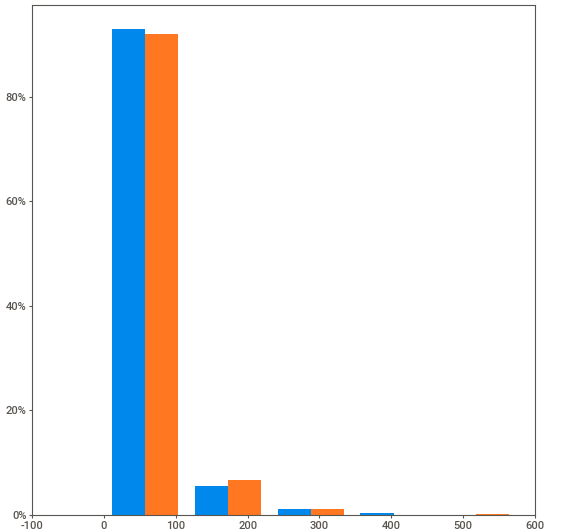
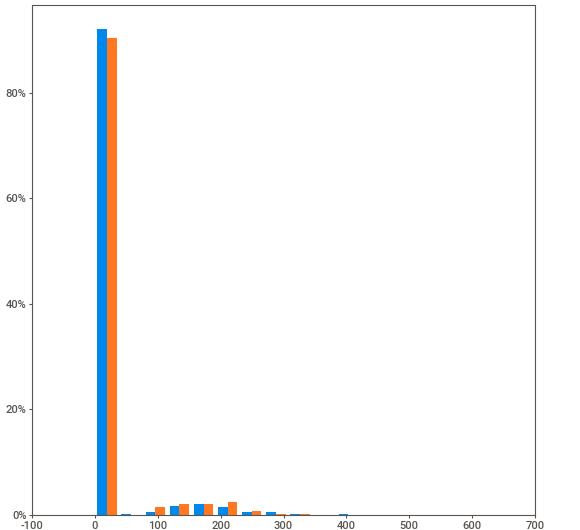
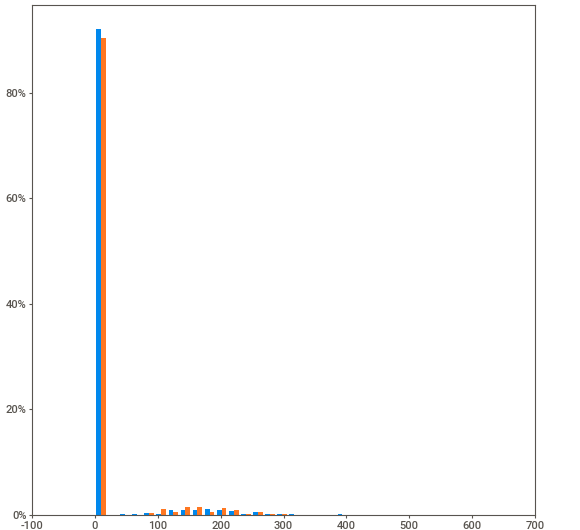
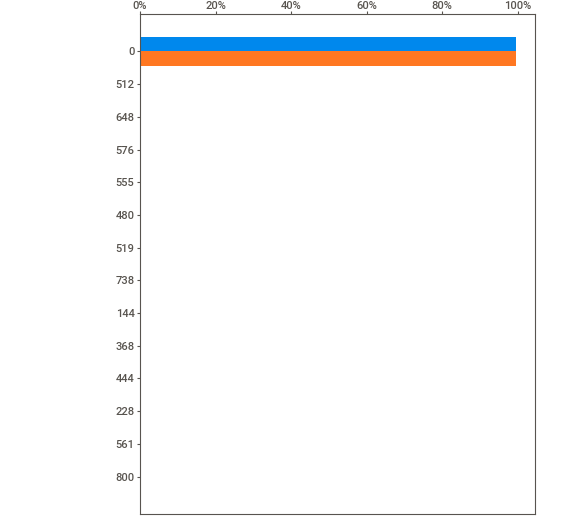
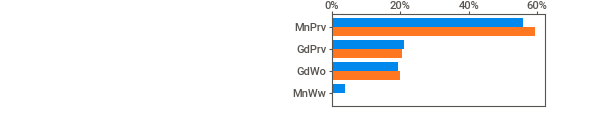
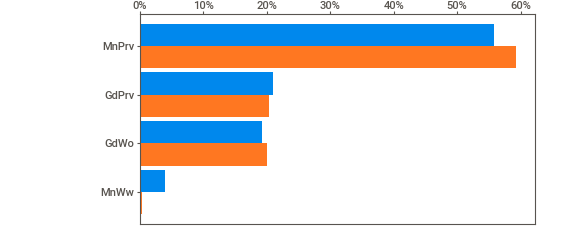
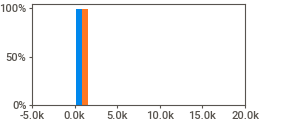
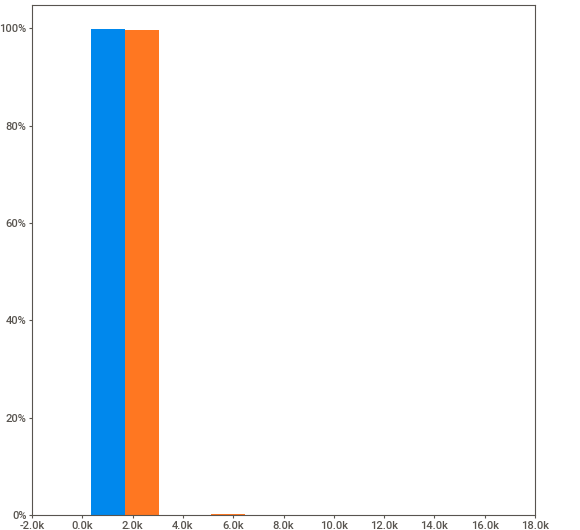
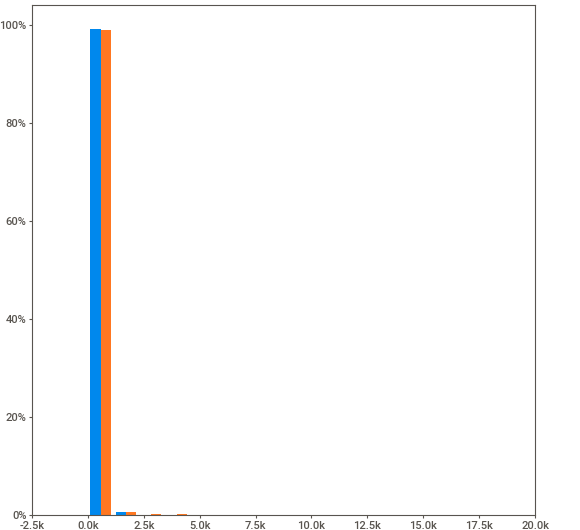
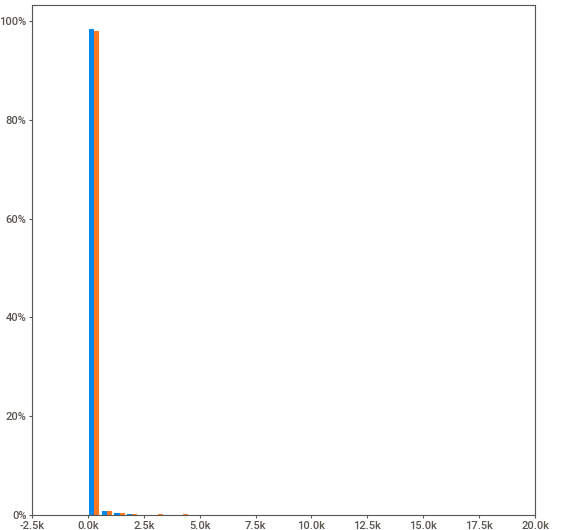
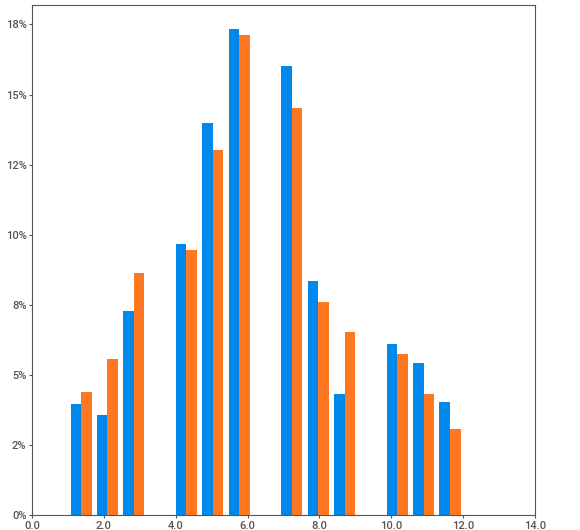
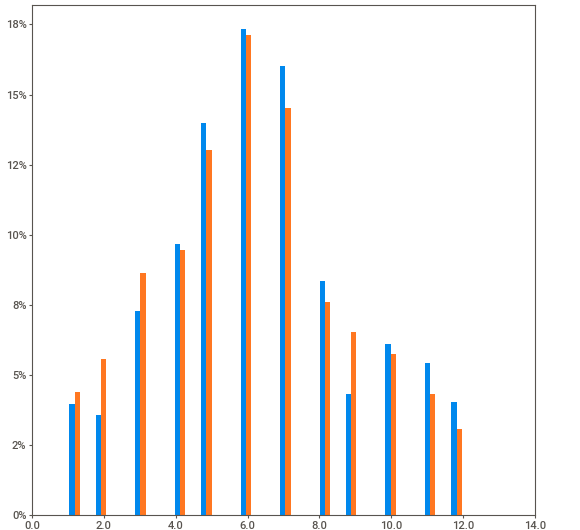
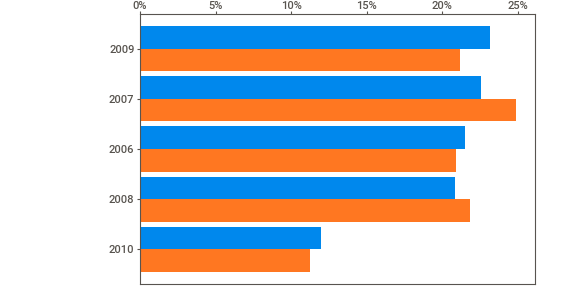
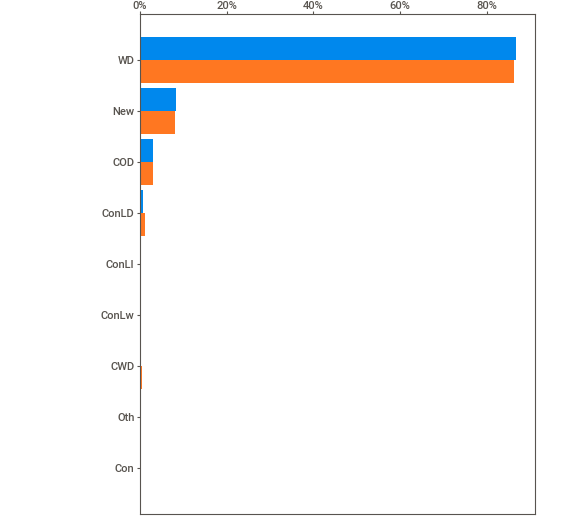
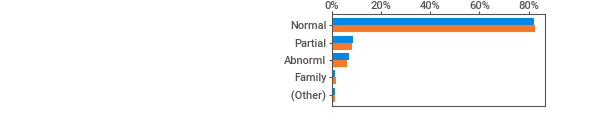
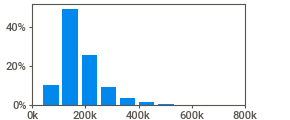
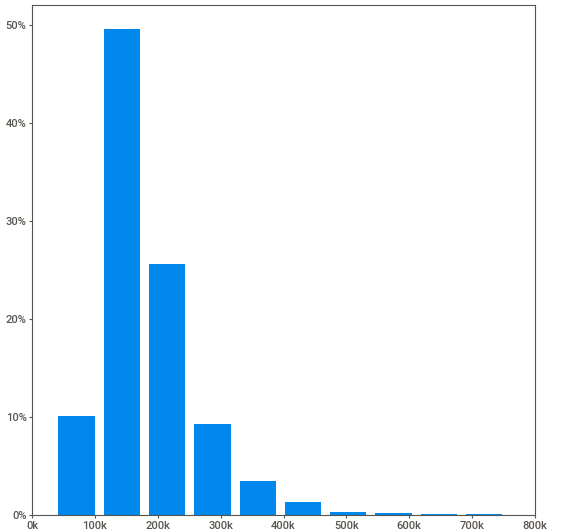
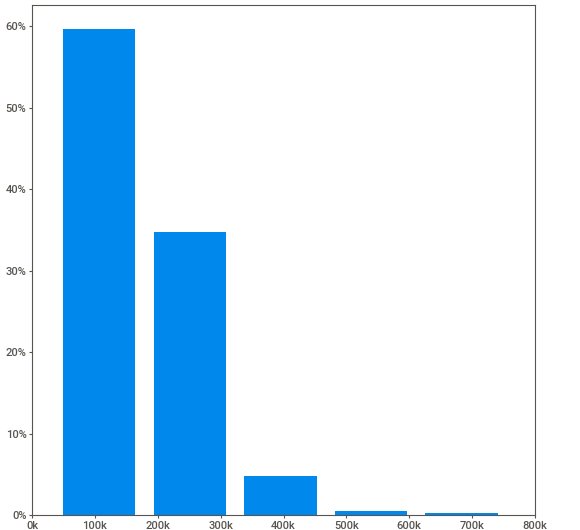
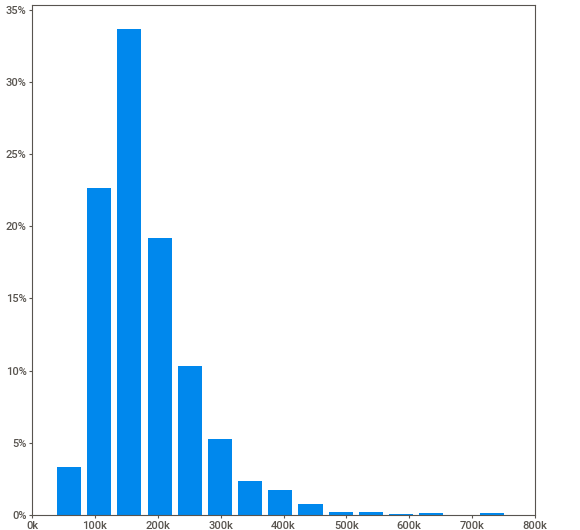
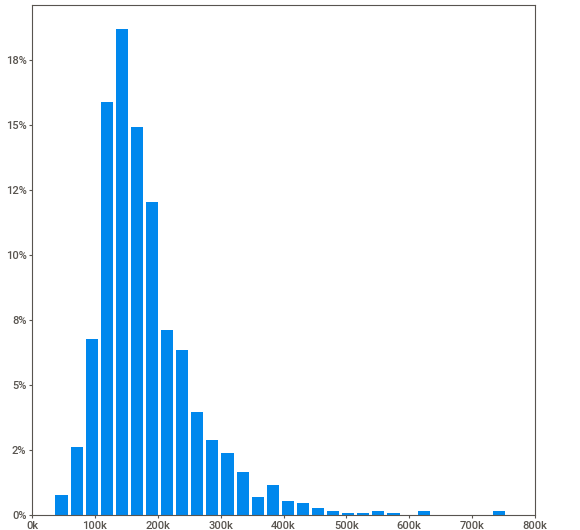
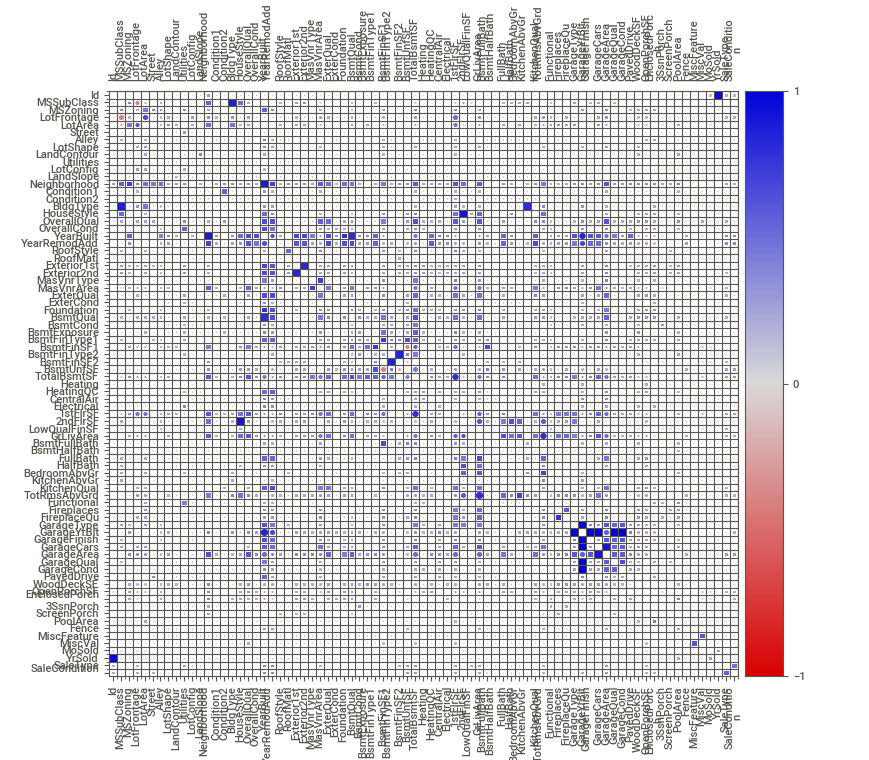

In [86]:
import sweetviz as sv
comparison = sv.compare(train, test)
comparison.show_notebook()

### Categorical Data

In [87]:
from sklearn.preprocessing import LabelEncoder

categorical_columns_train = train.select_dtypes(include=['object']).columns.tolist()

# cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
#         'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
#         'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
#         'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
#         'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
dic = []
for c in categorical_columns_train:
    lbl = LabelEncoder() 
    lbl.fit(list(train[c].values)) 
    train[c] = lbl.transform(list(train[c].values))
    
    l = LabelEncoder()
    l.fit_transform(train[c].values)
    k = l.classes_
    v = l.transform(k)
    d = dict(zip(k,v))
    dic.append(d)

# shape        
# print('Shape all_data: {}'.format(train.shape))

### Numerical Data

In [88]:
## Removing outliers

def remove_outliers(dataset, variables):
    for i, var_name in enumerate(variables):
        q1 = dataset[var_name].quantile(0.25)
        q3 = dataset[var_name].quantile(0.75)
        iqr = q3 - q1
        upper_limit = q3 + 1.5 * iqr
        lower_limit = q1 - 1.5 * iqr
#         print('variable name : ', var_name)
#         print('Q1 : ', q1)
#         print('Q3 : ', q3)
#         print('upper limit : ', upper_limit)
#         print('lower limit : ', lower_limit)
#         print('*' * 20)
        
        dataset[var_name] = np.where(dataset[var_name] > upper_limit, upper_limit, np.where(dataset[var_name]<lower_limit, lower_limit, dataset[var_name]))

In [89]:
numeric_train_df = train.select_dtypes(include = np.number)
numeric_cols = numeric_train_df.columns
remove_outliers(train, numeric_cols)

### Normalization

In [90]:
def impute(df):
    # Find numerical and categorical columns (excluding SalePrice)
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).drop(columns=['SalePrice']).columns.tolist()
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Fill missing values for numerical columns with median
    for col in numerical_columns:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)

    # Fill missing values for categorical columns with mode
    for col in categorical_columns:
        mode_value = df[col].mode()[0]  # mode() returns a DataFrame, so we select the first value
        df[col].fillna(mode_value, inplace=True)
    
    return df

In [91]:
data = pd.concat([train, test])
data = impute(data)
# data.fillna(0, inplace=True)

data.drop("Id", axis=1, inplace=True)
column_to_drop = ['GarageArea','2ndFlrSF','GarageYrBlt','TotRmsAbvGrd']
data.drop(column_to_drop, axis=1, inplace=True)
# log >> 분포가 한쪽으로 쏠려있어서 log함수를 통해 맞춰준다! >> V

column_to_drop = ['MiscFeature', 'Fence', 'PoolQC', 'FireplaceQu', 'MasVnrType', 'Alley', 'LotFrontage']
data.drop(column_to_drop, axis=1, inplace=True)

In [92]:
#로그변환 : 로그 변환은 데이터의 분포를 정규분포에 가깝게 만들거나, 특정 모델에 적합하게 만들기 위해 종종 사용
data["YearBuilt"] = data["YearBuilt"].apply(lambda x : np.log(x))
data["LotArea"]   = data["LotArea"].apply(lambda x : np.log(x))

#범주형, 숫자형 리스트 생성
categrocial_features = data.select_dtypes(include = ["object"]).columns
numerical_features = data.select_dtypes(exclude=["object"]).columns.tolist()
numerical_features.remove('SalePrice')

#각각 독립변수와 종속변수
y = train["SalePrice"]
X = pd.get_dummies(data.drop("SalePrice", axis = 1))

# Clustering Cloumn creation
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)

kmeans.fit(X[numerical_features])
cluster_labels = kmeans.labels_

X['cluster'] = cluster_labels
X['cluster'] = X['cluster']
X['cluster'] = X['cluster'].astype('int')

#표준화
scaler = StandardScaler() #표준화 객체 생성
X[numerical_features] = scaler.fit_transform(X[numerical_features]) #숫자형변수들 표준화 

/opt/homebrew/Caskroom/miniforge/base/envs/reg/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [93]:
#종속변수
y = y.apply(lambda x : np.log(x)) #종속변수를 로그변환
y = y.values.reshape(-1, 1) #종속변수 형태를 재구성
y = scaler.fit_transform(y) #종속변수를 표준화
y= pd.DataFrame(y, columns=['SalePrice'])
y

SalePrice
0      0.612476
1      0.246843
2      0.795638
3     -0.437616
4      1.091052
...         ...
1455   0.150693
1456   0.631376
1457   1.259556
1458  -0.397899
1459  -0.300031

[1460 rows x 1 columns]

In [111]:
#학습용과 검증용으로 나눔
X_t = X.iloc[:len(train), :]
X_test = X.iloc[len(train):, :]

X_train, X_val ,Y_train,y_val = train_test_split(X_t, y, test_size=0.01, random_state=42)

### Modeling

-------------------------------------------------------
classification / Regression

X[column data] --> Categorical && Numerical
Y              --> Classifying || Regression

Titanic, Space-Tatinc --> Survive ? 0/1 --> classification

House PP --> Price --> 0 - 1 prediction -> Regression

-------------------------------------------------------

최적의 모델링을 해주기위한 방법

전제: Data Normalize, Scale Transform까지 완료된 데이터 X, Y 가 존재함.

1. Model A,B,C,D 를 동일한 데이터에 대해서 성능 측정을 해줌

2. A,B,C,D 개별 Hyperparameter를 찾아줌

3-1. Train Dataset에 대해서 Cross Validation 함

3-2. Cross Validation 한 데이터셋 들에 대해서 Model A,B,C,D를 학습함

4. Meta-Model (A,B,C,D의 결과치를 종합할 수 있는 상위 모델)을 결과치와 GT에 fit 시킴

5. Meta-Model에 대한 Test dataset Prediction

6. Submit results

### Checking Individual Model and Searching HyperParams

##### XGBRegressor

In [112]:
from sklearn.model_selection import cross_val_score

param = {
    'max_depth': 4,            
    'objective': 'reg:squarederror',  
    'learning_rate': 0.1,   
    'n_estimators': 300,       
    'subsample': 0.79,          
    'colsample_bytree': 0.8,    
    'eval_metric': 'rmse'       
}

model = XGBRegressor(**param)
model.fit(X_train, Y_train)
y_pred = model.predict(X_val)


mse = mean_squared_error(y_val, y_pred)
print("Mean squarred error on validation set:", mse)

y_test = model.predict(X_test)
y_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_sub = pd.DataFrame({'SalePrice': np.exp(y_unscaled).flatten()})
submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': y_sub["SalePrice"] })

Mean squarred error on validation set: 0.07085309854976395


##### ElasticNet

In [113]:
from sklearn.model_selection import cross_val_score

param = {
    'max_depth': 4,            
    'objective': 'reg:squarederror',  
    'learning_rate': 0.1,   
    'n_estimators': 300,       
    'subsample': 0.79,          
    'colsample_bytree': 0.8,    
    'eval_metric': 'rmse'       
}

model = ElasticNet(random_state=42)

model.fit(X_train, Y_train)
y_pred = model.predict(X_val)


mse = mean_squared_error(y_val, y_pred)
print("Mean squarred error on validation set:", mse)

y_test = model.predict(X_test)
y_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_sub = pd.DataFrame({'SalePrice': np.exp(y_unscaled).flatten()})
submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': y_sub["SalePrice"] })

Mean squarred error on validation set: 0.9436277535246934


### Ensemble / OOF Prediction Code

In [117]:
# Prepare cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

param = {
    'max_depth': 4,            
    'objective': 'reg:squarederror',  
    'learning_rate': 0.1,   
    'n_estimators': 300,       
    'subsample': 0.79,          
    'colsample_bytree': 0.8,    
    'eval_metric': 'rmse'       
}


# Define base models
# models = [
#     # RandomForestRegressor(n_estimators=300, random_state=42),
#     GradientBoostingRegressor(n_estimators=100, random_state=42),
#     XGBRegressor(**param)
# ]
models = [
    # RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    XGBRegressor(**param),
    # LGBMRegressor(n_estimators=100, random_state=42),
    CatBoostRegressor(n_estimators=100, random_state=42, verbose=0), # CatBoost의 verbose=0은 학습 중 메시지 출력을 방지합니다.
    # NuSVR(),
    ElasticNet(random_state=42)
]


# Collect out-of-fold predictions
oof_preds = np.zeros((X_t.shape[0], len(models)))

# Cross-validation loop
for train_idx, test_idx in kf.split(X_t):
    X_train, X_val = X_t.iloc[train_idx], X_t.iloc[test_idx]
    Y_train, Y_val = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train and predict with each base model
    for i, model in enumerate(models):
        model.fit(X_train, Y_train)
        preds = model.predict(X_val)
        oof_preds[test_idx, i] = preds
        

# Train meta-model on out-of-fold predictions
# meta_model = LinearRegression().fit(oof_preds, y)
meta_model = RandomForestRegressor(n_estimators=100, random_state=42)
# meta_model = CatBoostRegressor(n_estimators=100, random_state=42).fit(oof_preds,y)

# Evaluate ensemble model with cross-validation on the original dataset
cv_scores = []
for train_idx, test_idx in kf.split(X_t):
    # Split data
    X_train, X_val = oof_preds[train_idx], oof_preds[test_idx]
    Y_train, Y_val = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train meta-model
    meta_model.fit(X_train, Y_train)
    
    # Predict and evaluate
    preds = meta_model.predict(X_val)
    score = mean_squared_error(Y_val, preds)
    cv_scores.append(score)

print(f"CV MSE Scores: {cv_scores}")
print(f"Mean CV MSE: {np.mean(cv_scores)}")

test_preds = np.zeros((X_test.shape[0], len(models)))
# 각 베이스 모델에 대해 반복
for i, model in enumerate(models):
    # 테스트 데이터에 대한 예측 생성
    preds = model.predict(X_test)
    test_preds[:, i] = preds

# 메타-모델을 사용하여 최종 예측 생성
final_preds = meta_model.predict(test_preds)

# 최종 예측을 원래 스케일로 변환 (만약 필요한 경우)
final_preds_unscaled = scaler.inverse_transform(final_preds.reshape(-1, 1))

# 최종 예측을 사용하여 제출 데이터프레임 생성
submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': np.exp(final_preds_unscaled).flatten()})

/opt/homebrew/Caskroom/miniforge/base/envs/reg/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/reg/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/reg/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/reg/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWar

CV MSE Scores: [0.12531604030215449, 0.09674067462559024, 0.16182972760049683, 0.12445315158820569, 0.09318830944752832]
Mean CV MSE: 0.12030558071279511


In [115]:
submission.to_csv('./submission.csv', index=False)

In [116]:
# Writing submitions to CSV file
submission[['Id', 'SalePrice']]


Id      SalePrice
0     1461  128975.960912
1     1462  152979.190043
2     1463  188684.227900
3     1464  183717.386143
4     1465  176092.920968
...    ...            ...
1454  2915  139502.932132
1455  2916  129938.738773
1456  2917  169922.724988
1457  2918  142989.442222
1458  2919  188397.878515

[1459 rows x 2 columns]